## Preprocessing

In [ ]:
import torch
import torch.nn as nn
from torch import nn, Tensor
from torch.utils.data import Dataset
import torch.nn.functional as F
import math
import os
import pandas as pd
import numpy as np
from typing import Tuple
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader
import datetime
from typing import Union
from pathlib import Path

In [ ]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/PJM_Load_hourly.csv')

series = df['PJM_Load_MW']
series_2 = df['Datetime']


In [ ]:
def get_indices_entire_sequence(data: pd.DataFrame, window_size: int, step_size: int) -> list:

        stop_position = len(data)-1 # 1- because of 0 indexing

        # Start the first sub-sequence at index position 0
        subseq_first_idx = 0

        subseq_last_idx = window_size

        indices = []

        while subseq_last_idx <= stop_position:

            indices.append((subseq_first_idx, subseq_last_idx))

            subseq_first_idx += step_size

            subseq_last_idx += step_size

        return indices


In [ ]:
def read_data(data_dir: Union[str, Path] = "data",
    timestamp_col_name: str="timestamp") -> pd.DataFrame:

    # Ensure that `data_dir` is a Path object
    data_dir = Path(data_dir)

    # Read csv file
    csv_files = list(data_dir.glob("*.csv"))

    if len(csv_files) > 1:
        raise ValueError("data_dir contains more than 1 csv file. Must only contain 1")
    elif len(csv_files) == 0:
	      raise ValueError("data_dir must contain at least 1 csv file.")

    data_path = csv_files[0]

    print("Reading file in {}".format(data_path))

    data = pd.read_csv(
        data_path,
        parse_dates=[timestamp_col_name],
        index_col=[timestamp_col_name],
        infer_datetime_format=True,
        low_memory=False
    )


    data.sort_values(by=[timestamp_col_name], inplace=True)

    return data

In [ ]:
data_dir='/content/drive/MyDrive/PJM_Load_hourly.csv'

In [ ]:
mydata = pd.read_csv(data_dir)

In [ ]:
main_dir='/content/drive/My Drive/thesis/preprocess/'
src_dir = os.path.join(main_dir , 'sampled')
if(not os.path.isdir(src_dir)):
    os.makedirs(src_dir)
mydata.to_csv(os.path.join(src_dir, 'NSW.csv'))

In [ ]:
#create date-time column in dataframe

mydata['Datetime']=mydata['Datetime'].astype(str)                     # concatenate date and hour
mydata['Datetime'] = pd.to_datetime(mydata['Datetime'], infer_datetime_format = True)            # change to datetime type
mydata

,Datetime,PJM_Load_MW
0,1998-12-31 01:00:00,29309.0
1,1998-12-31 02:00:00,28236.0
2,1998-12-31 03:00:00,27692.0
3,1998-12-31 04:00:00,27596.0
4,1998-12-31 05:00:00,27888.0
...,...,...
32891,2001-01-01 20:00:00,35209.0
32892,2001-01-01 21:00:00,34791.0
32893,2001-01-01 22:00:00,33669.0
32894,2001-01-01 23:00:00,31809.0


In [ ]:
data = read_data(src_dir,timestamp_col_name="Datetime")

Reading file in /content/drive/My Drive/thesis/preprocess/sampled/NSW.csv


In [ ]:
#normalization


nb_time = len(data)
nb_val = int(nb_time*0.8)

train, test = data[:nb_val], data[nb_val:]

scaler_E=StandardScaler()

E_train_scaled=scaler_E.fit_transform(train.PJM_Load_MW.values.reshape(-1, 1))   #E is the same as SYSLoad
E_test_scaled=scaler_E.transform(test.PJM_Load_MW.values.reshape(-1, 1))

data['PJM_Load_MW']=np.concatenate((E_train_scaled,E_test_scaled), axis=0)

data.to_csv(os.path.join(src_dir, 'NSW.csv'))

In [ ]:
class Dataset_generator(Dataset):

    def __init__(self,
        #myscaler:any,
        data: torch.tensor,
        indices: list,
        input_seq_len: int,
        output_seq_len: int
        ) -> None:



        super().__init__()



        self.indices = indices

        self.data = data



        self.input_seq_len = input_seq_len



        self.output_seq_len = output_seq_len



    def __len__(self):

        return len(self.indices)

    def __getitem__(self, index):

        # Get the first element of the i'th tuple in the list self.indicesasdfas
        start_idx = self.indices[index][0]

        # Get the second (and last) element of the i'th tuple in the list self.indices
        end_idx = self.indices[index][1]

        sequence = self.data[start_idx:end_idx]





        src, trg = self.get_src_trg(

            sequence=sequence,
            input_seq_len=self.input_seq_len,
            output_seq_len=self.output_seq_len
            )

        return src, trg

    def get_src_trg(
        self,
        sequence: torch.Tensor,
        input_seq_len: int,
        output_seq_len: int
        ) -> Tuple[torch.tensor, torch.tensor]:



        assert len(sequence) == input_seq_len + output_seq_len, "Sequence length does not equal (input length + target length)"

        # encoder input
        src = sequence[:input_seq_len]




        trg_y = sequence[-output_seq_len:]

        if len(trg_y.shape) == 1:  #new

           trg_y = trg_y.unsqueeze(-1)          #new

        assert len(trg_y) == output_seq_len, "Length of trg_y does not match target sequence length"

        return src.unsqueeze(-1),trg_y   #.squeeze(-1) # change size from [batch_size, output_seq_len, num_features] to [batch_size, output_seq_len]


In [ ]:
# change it based on your dataset
training_data = data[:nb_val]    #80 % of dataset
validation_data = data[nb_val:]   #20 % of dataset

In [ ]:
def prepare_data(input_seq_len, output_sequence_length, step_size, training_data, validation_data, batch_size):
    window_size = input_seq_len + output_sequence_length

    training_indices = get_indices_entire_sequence(
        data=training_data,
        window_size=window_size,
        step_size=step_size)

    validation_indices = get_indices_entire_sequence(
        data=validation_data,
        window_size=window_size,
        step_size=step_size)

    # Making instance of custom dataset class
    training_data = Dataset_generator(
        data=torch.tensor(training_data['PJM_Load_MW'].values).float(),
        indices=training_indices,
        input_seq_len=input_seq_len,
        output_seq_len=output_sequence_length,
    )

    validation_data = Dataset_generator(
        data=torch.tensor(validation_data['PJM_Load_MW'].values).float(),
        indices=validation_indices,
        input_seq_len=input_seq_len,
        output_seq_len=output_sequence_length,
    )

    # Making dataloader
    training_data_load = DataLoader(training_data, batch_size)
    validation_data_load = DataLoader(validation_data, batch_size)

    return training_data_load, validation_data_load, training_data, validation_data


In [ ]:
input_seq_len = 24  #input to model previous day
output_sequence_length  = 6  #prediction horizon
step_size = 1
batch_size = 1024

training_data_load, validation_data_load, training_data, validation_data= prepare_data(input_seq_len, output_sequence_length, step_size, training_data, validation_data, batch_size)


## Models

In [ ]:
class LSTMNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTMNet, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(
            input_size=input_size, hidden_size=hidden_size,
            num_layers=num_layers, batch_first=True
        )

        self.fc1 = nn.Linear(hidden_size,40)
        self.fc2 = nn.Linear(40,1)
        self.relu = nn.ReLU()

    def forward(self, x):
      batch_size = x.size(0)
      seq_len = x.size(1)

      h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
      c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)

      h_out, _ = self.lstm(x, (h0, c0))
      h_out = h_out[:, -1, :]  # Take the final hidden state from the last time step

      out = self.fc2(self.relu(self.fc1(h_out)))

      return out

In [ ]:
#LSTM
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers,forecast_window):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_seq = forecast_window
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Initialize hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))

        # Decode the hidden state of the last time step
        out = self.fc(out[:, -self.output_seq:, :])  # select the last 48 time steps and pass through fully connected layer
        # print(out.shape)

        return out

In [ ]:
import torch
import torch.nn as nn

class RNNNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(RNNNet, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.rnn = nn.RNN(
            input_size=input_size, hidden_size=hidden_size,
            num_layers=num_layers, batch_first=True
        )

        self.fc1 = nn.Linear(hidden_size, 40)
        self.fc2 = nn.Linear(40, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        batch_size = x.size(0)
        seq_len = x.size(1)

        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)

        h_out, _ = self.rnn(x, h0)
        h_out = h_out[:, -1, :]  # Take the final hidden state from the last time step

        out = self.fc2(self.relu(self.fc1(h_out)))

        return out


In [ ]:
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, forecast_window):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_seq = forecast_window
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Initialize hidden state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Forward propagate RNN
        out, _ = self.rnn(x, h0)

        # Decode the hidden state of the last time step
        out = self.fc(out[:, -self.output_seq:, :])  # select the last 48 time steps and pass through fully connected layer

        return out


In [ ]:
import torch
import torch.nn as nn

class GRUNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(GRUNet, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.gru = nn.GRU(
            input_size=input_size, hidden_size=hidden_size,
            num_layers=num_layers, batch_first=True
        )

        self.fc1 = nn.Linear(hidden_size, 40)
        self.fc2 = nn.Linear(40, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        batch_size = x.size(0)
        seq_len = x.size(1)

        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)

        h_out, _ = self.gru(x, h0)
        h_out = h_out[:, -1, :]  # Take the final hidden state from the last time step

        out = self.fc2(self.relu(self.fc1(h_out)))

        return out


In [ ]:
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, forecast_window):
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_seq = forecast_window
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Initialize hidden state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Forward propagate GRU
        out, _ = self.gru(x, h0)

        # Decode the hidden state of the last time step
        out = self.fc(out[:, -self.output_seq:, :])  # select the last 48 time steps and pass through the fully connected layer

        return out


## Experiments

In [ ]:
def train_model(model, criterion, optimizer, training_data_load, validation_data_load, epochs):
    early_stopping_patience = 150
    early_stopping_counter = 0

    train_loss = []
    val_loss = []

    for epoch in range(epochs):
        model.train()

        for i, (input, output) in enumerate(training_data_load):
            input = input.to(device)
            output = output.to(device)
            optimizer.zero_grad()

            pred = model(input)
            loss_tr = criterion(output, pred)

            loss_tr.backward()

            optimizer.step()

        train_loss.append(loss_tr.item())

        model.eval()
        with torch.no_grad():
            for i, (input, output) in enumerate(validation_data_load):
                input = input.to(device)
                output = output.to(device)

                pred = model(input)
                loss_val = criterion(output, pred)

            val_loss.append(loss_val.item())

            print(f'epoch {epoch} --> train loss: {loss_tr.item()}, val loss: {loss_val.item()}')


In [ ]:
EPOCHS = 50
LEARNING_RATE = 0.0001
device = 'cuda' if torch.cuda.is_available() else 'cpu'

forecast_window = output_sequence_length
input_size = 1
num_layers = 2
output_size = 1
hidden_size = 100
model_LSTM = LSTMModel(input_size, hidden_size, output_size, num_layers,forecast_window)
criterion = torch.nn.MSELoss()
model_LSTM.to(device)
optimizer = torch.optim.Adam(model_LSTM.parameters(), lr = LEARNING_RATE)

In [ ]:
train_model(model_LSTM, criterion, optimizer, training_data_load, validation_data_load, EPOCHS)

epoch 0 --> train loss: 0.4060194790363312, val loss: 0.4764327108860016
epoch 1 --> train loss: 0.4057468771934509, val loss: 0.4779675602912903
epoch 2 --> train loss: 0.4057404696941376, val loss: 0.4799114167690277
epoch 3 --> train loss: 0.40606600046157837, val loss: 0.48254305124282837
epoch 4 --> train loss: 0.4069133698940277, val loss: 0.48630982637405396
epoch 5 --> train loss: 0.4086178243160248, val loss: 0.49192702770233154
epoch 6 --> train loss: 0.41149231791496277, val loss: 0.5002161264419556
epoch 7 --> train loss: 0.4138210415840149, val loss: 0.5060535073280334
epoch 8 --> train loss: 0.38265174627304077, val loss: 0.4446527063846588
epoch 9 --> train loss: 0.34217369556427, val loss: 0.3789990544319153
epoch 10 --> train loss: 0.3118796646595001, val loss: 0.34691664576530457
epoch 11 --> train loss: 0.3024062216281891, val loss: 0.32976439595222473
epoch 12 --> train loss: 0.2943248152732849, val loss: 0.31894731521606445
epoch 13 --> train loss: 0.28985133767127

In [ ]:
EPOCHS = 50
LEARNING_RATE = 0.0001
device = 'cuda' if torch.cuda.is_available() else 'cpu'

forecast_window = output_sequence_length
input_size = 1
num_layers = 2
output_size = 1
hidden_size = 100
model_RNN = RNNModel(input_size, hidden_size, output_size, num_layers,forecast_window)
criterion = torch.nn.MSELoss()
model_RNN.to(device)
optimizer = torch.optim.Adam(model_RNN.parameters(), lr = LEARNING_RATE)

In [ ]:
train_model(model_RNN, criterion, optimizer, training_data_load, validation_data_load, EPOCHS)

epoch 0 --> train loss: 0.4143590033054352, val loss: 0.49842339754104614
epoch 1 --> train loss: 0.4147825837135315, val loss: 0.501163125038147
epoch 2 --> train loss: 0.42354482412338257, val loss: 0.5144419074058533
epoch 3 --> train loss: 0.43125584721565247, val loss: 0.5257315635681152
epoch 4 --> train loss: 0.4344586730003357, val loss: 0.5308498740196228
epoch 5 --> train loss: 0.4359145760536194, val loss: 0.5336534976959229
epoch 6 --> train loss: 0.43687885999679565, val loss: 0.5358651280403137
epoch 7 --> train loss: 0.4369875490665436, val loss: 0.5370817184448242
epoch 8 --> train loss: 0.42759665846824646, val loss: 0.5240358114242554
epoch 9 --> train loss: 0.3361073434352875, val loss: 0.3714312016963959
epoch 10 --> train loss: 0.31912750005722046, val loss: 0.34015122056007385
epoch 11 --> train loss: 0.3130999207496643, val loss: 0.3492635190486908
epoch 12 --> train loss: 0.3051367402076721, val loss: 0.33530741930007935
epoch 13 --> train loss: 0.34450030326843

In [ ]:
EPOCHS = 50
LEARNING_RATE = 0.0001
device = 'cuda' if torch.cuda.is_available() else 'cpu'

forecast_window = output_sequence_length
input_size = 1
num_layers = 2
output_size = 1
hidden_size = 100
model_GRU = GRUModel(input_size, hidden_size, output_size, num_layers,forecast_window)
criterion = torch.nn.MSELoss()
model_GRU.to(device)
optimizer = torch.optim.Adam(model_GRU.parameters(), lr = LEARNING_RATE)

In [ ]:
train_model(model_GRU, criterion, optimizer, training_data_load, validation_data_load, EPOCHS)

epoch 0 --> train loss: 0.40551018714904785, val loss: 0.4795469045639038
epoch 1 --> train loss: 0.4075358808040619, val loss: 0.4872622489929199
epoch 2 --> train loss: 0.41148534417152405, val loss: 0.4961153566837311
epoch 3 --> train loss: 0.41620802879333496, val loss: 0.504797637462616
epoch 4 --> train loss: 0.4203612506389618, val loss: 0.5117403864860535
epoch 5 --> train loss: 0.42313554883003235, val loss: 0.5162404775619507
epoch 6 --> train loss: 0.4245525002479553, val loss: 0.5186998844146729
epoch 7 --> train loss: 0.42491215467453003, val loss: 0.5197688937187195
epoch 8 --> train loss: 0.4241115152835846, val loss: 0.519464910030365
epoch 9 --> train loss: 0.42049071192741394, val loss: 0.5155903697013855
epoch 10 --> train loss: 0.4056333005428314, val loss: 0.49488791823387146
epoch 11 --> train loss: 0.36194613575935364, val loss: 0.42166903614997864
epoch 12 --> train loss: 0.30817630887031555, val loss: 0.33906060457229614
epoch 13 --> train loss: 0.286106795072

## Plots and Results

In [ ]:
#RMSE MAPE
def RMSE(predictions, targets):
    return torch.sqrt(torch.mean((predictions - targets)**2))

def MAPE(predictions, targets):
    return torch.mean(torch.abs((targets - predictions) / targets)*100)

def Average(lst):
    return sum(lst) / len(lst)

In [ ]:
import matplotlib.pyplot as plt

def plotting(pred, out, title):
    fig = plt.figure(facecolor='white', figsize=(12, 6))
    ax = fig.add_subplot(111)
    ax.plot(pred[-1000:], label='True Data')
    plt.plot(out[-1000:], label='Prediction')
    plt.legend()
    plt.title(title)
    plt.show()

In [ ]:
import torch

def calculate_metrics(model, validation_data_load, scaler_E, device):
    RMSE_result_test = []
    MAPE_result_test = []
    predictions = []
    true_values = []

    model.to(device)
    model.eval()

    with torch.no_grad():
        for i, (input, output) in enumerate(validation_data_load):
            input = input.to(device)
            output = output.to(device)

            prediction = model(input)

            # Use inverse of scaler that we used for normalization for both y_true and prediction
            prediction = scaler_E.inverse_transform(prediction.detach().cpu().numpy().squeeze(-1))
            prediction = torch.tensor(prediction)
            prediction = prediction.unsqueeze(-1).to(device)

            output = scaler_E.inverse_transform(output.detach().cpu().numpy().squeeze(-1))
            output = torch.tensor(output)
            output = output.unsqueeze(-1).to(device)

            predictions.append(np.array(prediction.detach().cpu().numpy()))
            true_values.append(np.array(output.detach().cpu().numpy()))

            RMSE_test = RMSE(prediction, output)
            MAPE_test = MAPE(prediction, output)

            RMSE_result_test.append(RMSE_test.item())
            MAPE_result_test.append(MAPE_test.item())

    RMSE_avg=Average(RMSE_result_test)
    MAPE_avg= Average(MAPE_result_test)
    predictions = np.concatenate(predictions)
    true_values = np.concatenate(true_values)
    pred = predictions[:,-1,:]
    out = true_values[:,-1,:]
    return RMSE_avg, MAPE_avg, pred, out


In [ ]:
RMSE_results1, MAPE_results1, pred1, out1 = calculate_metrics(model_LSTM, validation_data_load, scaler_E, device)
print('The mean square error is: %f' % RMSE_results1)
print('MAPE is: %f' % MAPE_results1)

The mean square error is: 3182.002197
MAPE is: 8.376873


In [ ]:
RMSE_results2, MAPE_results2, pred2, out2 = calculate_metrics(model_RNN, validation_data_load, scaler_E, device)
print('The mean square error is: %f' % RMSE_results2)
print('MAPE is: %f' % MAPE_results2)

The mean square error is: 2700.414900
MAPE is: 6.968240


In [ ]:
RMSE_results3, MAPE_results3, pred3, out3 = calculate_metrics(model_GRU, validation_data_load, scaler_E, device)
print('The mean square error is: %f' % RMSE_results3)
print('MAPE is: %f' % MAPE_results3)

The mean square error is: 3068.104736
MAPE is: 8.044114


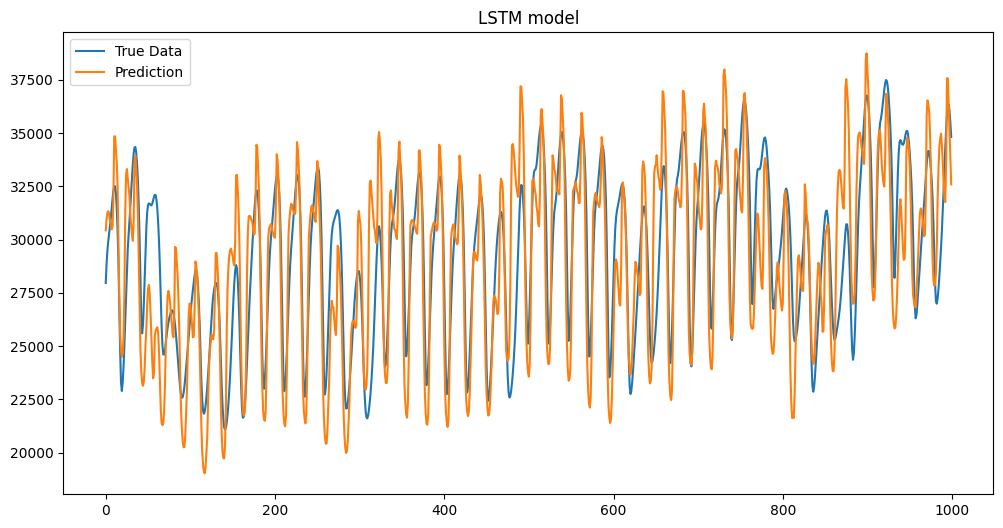

In [ ]:
plotting(pred1, out1, 'LSTM model')

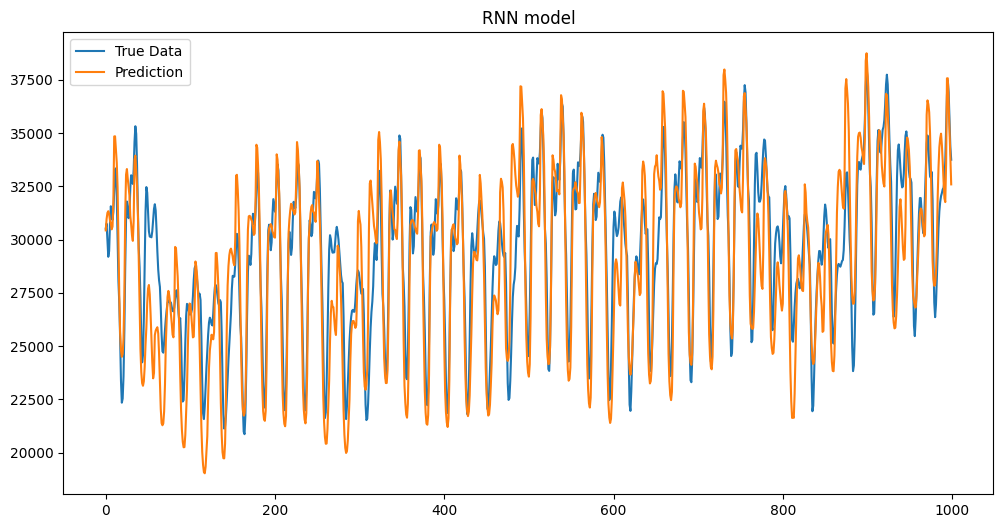

In [ ]:
plotting(pred2, out2, 'RNN model')

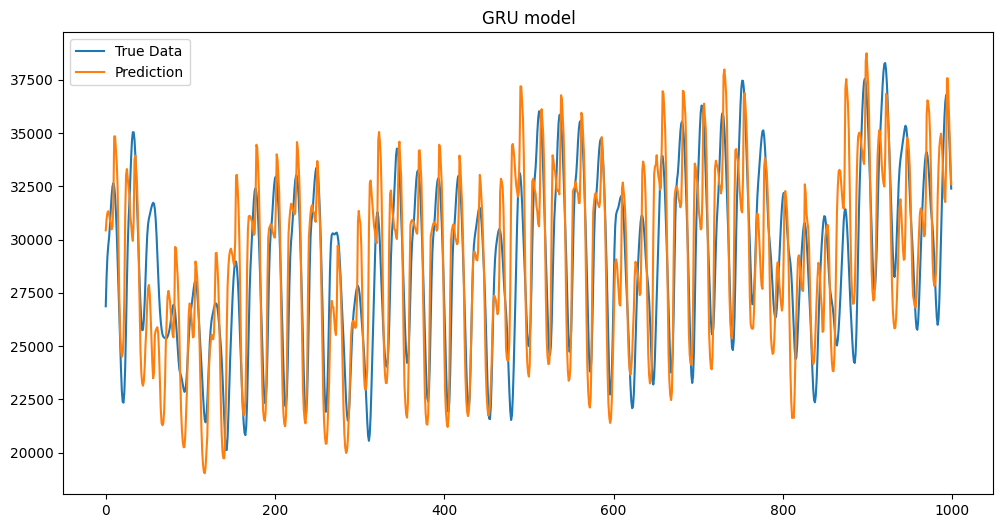

In [ ]:
plotting(pred3, out3, 'GRU model')

## Wavelet-driven STLF

## Preprocessing

In [ ]:
import pandas as pd
import numpy as np
from sklearn import preprocessing

import time
import matplotlib.pyplot as plt
from numpy import newaxis

def load_data(data_path,P,step):
    num_logs = P+step
    df = pd.read_csv(data_path)


    data_np = np.zeros((len(df),num_logs))
    data_df_combined = pd.DataFrame(data_np)
    data_df_combined.loc[:,0] = df['PJM_Load_MW'].values

    for i in range(1, num_logs):
        data_df_combined.loc[:,i] = data_df_combined.shift(-i)

    data_df_combined_clean = data_df_combined.dropna()
    data_df_combined_clean = data_df_combined_clean.reset_index()
    data_df_combined_clean.drop('index',axis=1,inplace=True)
    data_combined_standardized = preprocessing.scale(data_df_combined_clean)

    train_split = round(0.8 * data_combined_standardized.shape[0])
    val_split = round(0.9 * data_combined_standardized.shape[0])
    #print("all len",data_combined_standardized.shape[0])
    #print("train_split",train_split)

    X = data_combined_standardized[:,:P]
    Y = data_combined_standardized[:,P:]

    X_train = X[:train_split]
    Y_train = Y[:train_split]
    X_test = X[train_split:]
    Y_test = Y[train_split:]

    X_train = X_train.reshape((X_train.shape[0],X_train.shape[1],1))
    Y_train = Y_train.reshape((Y_train.shape[0],Y_train.shape[1],1))
    X_test = X_test.reshape((X_test.shape[0],X_test.shape[1],1))
    Y_test = Y_test.reshape((Y_test.shape[0],Y_test.shape[1],1))

    return X_train,Y_train,X_test,Y_test,data_df_combined_clean


In [ ]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

use_cuda = torch.cuda.is_available()

class TorchDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

    def __len__(self):
        return len(self.x)

class TorchDataLoader:
    def __init__(self,batch_size,shuffle = True):
        self.batch_size = batch_size
        self.shuffle = shuffle

    def torch_dataloader(self,train_data,target_data):
        torch_dataset = TorchDataset(train_data,target_data)
        torch_loader = DataLoader(dataset = torch_dataset,
                                batch_size = self.batch_size,
                                shuffle = self.shuffle)
        return torch_loader

def plot_results(predicted_data, true_data):
    # use in train.py
    # plot evaluate result
    fig = plt.figure(facecolor='white', figsize=(12, 6))
    ax = fig.add_subplot(111)
    ax.plot(true_data[-1000:], label='True Data')
    plt.plot(predicted_data[-1000:], label='Prediction')
    plt.legend()
    plt.show()

def ToVariable(x):
    # use in train.py
    # change from numpy.array to torch.variable
    tmp = torch.DoubleTensor(x)
    return Variable(tmp)



## Wavelet models

In [ ]:
import math
import torch
import torch.nn as nn
import torch.nn.init as init
from torch.nn.parameter import Parameter
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
import numpy as np
import h5py
from torch.utils.data import DataLoader, Dataset
import pywt

class Wavelet_LSTM(nn.Module):
    def __init__(self, seq_len, hidden_size, output_size, num_rnn_levels):
        super(Wavelet_LSTM, self).__init__()

        self.seq_len = seq_len
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_rnn_levels = num_rnn_levels

        self.lstms = nn.ModuleList([nn.LSTM(1, hidden_size, batch_first=True) for _ in range(num_rnn_levels)])
        self.mWDNs = nn.ModuleList([nn.Linear(int(seq_len / (2 ** i)), int(seq_len / (2 ** i))) for i in range(num_rnn_levels)])

        self.a_to_x = nn.AvgPool1d(2)
        self.sigmoid = nn.Sigmoid()
        self.output = nn.Linear(hidden_size, output_size)

        wavelet = pywt.Wavelet('db4')
        low = wavelet.dec_lo
        high = wavelet.dec_hi
        self.l_filter = low
        self.h_filter = high

        self.cmp_mWDNs_H = nn.ParameterList([nn.Parameter(torch.tensor(self.create_W(int(seq_len / (2 ** i)), False, is_comp=True)).double()) for i in range(num_rnn_levels)])
        self.cmp_mWDNs_L = nn.ParameterList([nn.Parameter(torch.tensor(self.create_W(int(seq_len / (2 ** i)), True, is_comp=True)).double()) for i in range(num_rnn_levels)])


        self.mWDNs_H = nn.ModuleList([nn.Linear(int(seq_len / (2 ** i)), int(seq_len / (2 ** i))) for i in range(num_rnn_levels)])
        self.mWDNs_L = nn.ModuleList([nn.Linear(int(seq_len / (2 ** i)), int(seq_len / (2 ** i))) for i in range(num_rnn_levels)])

        for i in range(num_rnn_levels):
            self.mWDNs_H[i].weight = nn.Parameter(torch.tensor(self.create_W(int(seq_len / (2 ** i)), False)).double())
            self.mWDNs_L[i].weight = nn.Parameter(torch.tensor(self.create_W(int(seq_len / (2 ** i)), True)).double())

    def forward(self, input, hidden_states):
        input = input.unsqueeze(-1)  # Reshape input tensor
        hidden_states = [(hidden_states[i][0].to(input.device), hidden_states[i][1].to(input.device)) for i in range(self.num_rnn_levels)]
        al = []
        ah = []
        xl =[]
        xh =[]
        # Wavelet decomposition layers
        ah.append(self.sigmoid(self.mWDNs_H[0](input.view(input.size(0), -1))))  # Adjust weight matrix dimensions
        al.append(self.sigmoid(self.mWDNs_L[0](input.view(input.size(0), -1))))  # Adjust weight matrix dimensions
        xh.append(self.a_to_x(ah[0].view(ah[0].shape[0], 1, -1)))

        xl.append(self.a_to_x(al[0].view(al[0].shape[0],1,-1)))
        for i in range(1,self.num_rnn_levels):
            ah.append(self.sigmoid(self.mWDNs_H[i](xl[i-1])))
            al.append(self.sigmoid(self.mWDNs_L[i](xl[i-1])))
            xh.append(self.a_to_x(ah[i]))
            xl.append(self.a_to_x(al[i]))

        # Transpose and apply LSTM layers
        xh = [x.transpose(1, 2) for x in xh]
        xl = [x.transpose(1, 2) for x in xl]
        rnn_outputs = []
        for i in range(self.num_rnn_levels):
            rnn_output, hidden = self.lstms[i](xh[i], hidden_states[i])
            rnn_outputs.append(rnn_output)

        rnn_outputs = torch.cat(rnn_outputs, 1)

        output = self.output(rnn_outputs)
        return output, hidden

    def init_state(self, batch_size):
        hidden_states = [(Variable(torch.zeros(1, batch_size, self.hidden_size)).double(),
                          Variable(torch.zeros(1, batch_size, self.hidden_size)).double())
                         for _ in range(self.num_rnn_levels)]
        return hidden_states

    def create_W(self, P, is_l, is_comp=False):
        if is_l:
            filter_list = self.l_filter
        else:
            filter_list = self.h_filter

        list_len = len(filter_list)

        max_epsilon = np.min(np.abs(filter_list))
        if is_comp:
            weight_np = np.zeros((P, P))
        else:
            weight_np = np.random.randn(P, P) * 0.1 * max_epsilon

        for i in range(0, P):
            filter_index = 0
            for j in range(i, P):
                if filter_index < len(filter_list):
                    weight_np[i][j] = filter_list[filter_index]
                    filter_index += 1
        return weight_np


In [ ]:
class Wavelet_RNN(nn.Module):
    def __init__(self, seq_len, hidden_size, output_size, num_rnn_levels):
        super(Wavelet_RNN, self).__init__()

        self.seq_len = seq_len
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_rnn_levels = num_rnn_levels

        self.rnns = nn.ModuleList([nn.RNN(1, hidden_size, batch_first=True) for _ in range(num_rnn_levels)])
        self.mWDNs = nn.ModuleList([nn.Linear(int(seq_len / (2 ** i)), int(seq_len / (2 ** i))) for i in range(num_rnn_levels)])

        self.a_to_x = nn.AvgPool1d(2)
        self.sigmoid = nn.Sigmoid()
        self.output = nn.Linear(hidden_size, output_size)

        wavelet = pywt.Wavelet('db4')
        low = wavelet.dec_lo
        high = wavelet.dec_hi
        self.l_filter = low
        self.h_filter = high

        self.cmp_mWDNs_H = nn.ParameterList([nn.Parameter(torch.tensor(self.create_W(int(seq_len / (2 ** i)), False, is_comp=True)).double()) for i in range(num_rnn_levels)])
        self.cmp_mWDNs_L = nn.ParameterList([nn.Parameter(torch.tensor(self.create_W(int(seq_len / (2 ** i)), True, is_comp=True)).double()) for i in range(num_rnn_levels)])




        self.mWDNs_H = nn.ModuleList([nn.Linear(int(seq_len / (2 ** i)), int(seq_len / (2 ** i))) for i in range(num_rnn_levels)])
        self.mWDNs_L = nn.ModuleList([nn.Linear(int(seq_len / (2 ** i)), int(seq_len / (2 ** i))) for i in range(num_rnn_levels)])

        for i in range(num_rnn_levels):
            #self.cmp_mWDNs_H.append(nn.Parameter(torch.tensor(self.create_W(int(seq_len / (2 ** i)), False, is_comp=True))))
            #self.cmp_mWDNs_L.append(nn.Parameter(torch.tensor(self.create_W(int(seq_len / (2 ** i)), True, is_comp=True))))
            self.mWDNs_H[i].weight = nn.Parameter(torch.tensor(self.create_W(int(seq_len / (2 ** i)), False)).double())
            self.mWDNs_L[i].weight = nn.Parameter(torch.tensor(self.create_W(int(seq_len / (2 ** i)), True)).double())

    def forward(self, input, hidden_states):

        input = input.view(input.shape[0], input.shape[1])
        hidden_states = [hidden_states[i].to(input.device) for i in range(self.num_rnn_levels)]
        al = []
        ah = []
        xl =[]
        xh =[]
        # Wavelet decomposition layers
        ah.append(self.sigmoid(self.mWDNs_H[0](input)))
        al.append(self.sigmoid(self.mWDNs_L[0](input)))
        xh.append(self.a_to_x(ah[0].view(ah[0].shape[0],1,-1)))
        xl.append(self.a_to_x(al[0].view(al[0].shape[0],1,-1)))
        for i in range(1,self.num_rnn_levels):
            ah.append(self.sigmoid(self.mWDNs_H[i](xl[i-1])))
            al.append(self.sigmoid(self.mWDNs_L[i](xl[i-1])))
            xh.append(self.a_to_x(ah[i]))
            xl.append(self.a_to_x(al[i]))

        # Transpose and apply RNN layers
        xh = [x.transpose(1, 2) for x in xh]
        xl = [x.transpose(1, 2) for x in xl]
        #to do xl[-1] append to xh
        rnn_outputs = []
        for i in range(self.num_rnn_levels):
            rnn_output, _ = self.rnns[i](xh[i], hidden_states[i])
            rnn_outputs.append(rnn_output)

        rnn_outputs = torch.cat(rnn_outputs, 1)

        output = self.output(rnn_outputs)
        return output

    def init_state(self, batch_size):
        hidden_states = [Variable(torch.zeros(1, batch_size, self.hidden_size)).double()
                         for _ in range(self.num_rnn_levels)]
        return hidden_states

    def create_W(self, P, is_l, is_comp=False):
        if is_l:
            filter_list = self.l_filter
        else:
            filter_list = self.h_filter

        list_len = len(filter_list)

        max_epsilon = np.min(np.abs(filter_list))
        if is_comp:
            weight_np = np.zeros((P, P))
        else:
            weight_np = np.random.randn(P, P) * 0.1 * max_epsilon

        for i in range(0, P):
            filter_index = 0
            for j in range(i, P):
                if filter_index < len(filter_list):
                    weight_np[i][j] = filter_list[filter_index]
                    filter_index += 1
        return weight_np


In [ ]:
class Wavelet_GRU(nn.Module):
    def __init__(self, seq_len, hidden_size, output_size, num_rnn_levels):
        super(Wavelet_GRU, self).__init__()

        self.seq_len = seq_len
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_rnn_levels = num_rnn_levels

        self.rnns = nn.ModuleList([nn.GRU(1, hidden_size, batch_first=True) for _ in range(num_rnn_levels)])
        self.mWDNs = nn.ModuleList([nn.Linear(int(seq_len / (2 ** i)), int(seq_len / (2 ** i))) for i in range(num_rnn_levels)])

        self.a_to_x = nn.AvgPool1d(2)
        self.sigmoid = nn.Sigmoid()
        self.output = nn.Linear(hidden_size, output_size)

        wavelet = pywt.Wavelet('db4')
        low = wavelet.dec_lo
        high = wavelet.dec_hi
        self.l_filter = low
        self.h_filter = high

        self.cmp_mWDNs_H = nn.ParameterList([nn.Parameter(torch.tensor(self.create_W(int(seq_len / (2 ** i)), False, is_comp=True)).double()) for i in range(num_rnn_levels)])
        self.cmp_mWDNs_L = nn.ParameterList([nn.Parameter(torch.tensor(self.create_W(int(seq_len / (2 ** i)), True, is_comp=True)).double()) for i in range(num_rnn_levels)])

        self.mWDNs_H = nn.ModuleList([nn.Linear(int(seq_len / (2 ** i)), int(seq_len / (2 ** i))) for i in range(num_rnn_levels)])
        self.mWDNs_L = nn.ModuleList([nn.Linear(int(seq_len / (2 ** i)), int(seq_len / (2 ** i))) for i in range(num_rnn_levels)])

        for i in range(num_rnn_levels):
            self.mWDNs_H[i].weight = nn.Parameter(torch.tensor(self.create_W(int(seq_len / (2 ** i)), False)).double())
            self.mWDNs_L[i].weight = nn.Parameter(torch.tensor(self.create_W(int(seq_len / (2 ** i)), True)).double())

    def forward(self, input, hidden_states):
        input = input.view(input.shape[0], input.shape[1])
        hidden_states = [hidden_states[i].to(input.device) for i in range(self.num_rnn_levels)]
        al = []
        ah = []
        xl =[]
        xh =[]
        # Wavelet decomposition layers
        ah.append(self.sigmoid(self.mWDNs_H[0](input)))
        al.append(self.sigmoid(self.mWDNs_L[0](input)))
        xh.append(self.a_to_x(ah[0].view(ah[0].shape[0],1,-1)))
        xl.append(self.a_to_x(al[0].view(al[0].shape[0],1,-1)))
        for i in range(1,self.num_rnn_levels):
            ah.append(self.sigmoid(self.mWDNs_H[i](xl[i-1])))
            al.append(self.sigmoid(self.mWDNs_L[i](xl[i-1])))
            xh.append(self.a_to_x(ah[i]))
            xl.append(self.a_to_x(al[i]))

        # Transpose and apply RNN layers
        xh = [x.transpose(1, 2) for x in xh]
        xl = [x.transpose(1, 2) for x in xl]
        rnn_outputs = []
        for i in range(self.num_rnn_levels):
            rnn_output, _ = self.rnns[i](xh[i], hidden_states[i])
            rnn_outputs.append(rnn_output)

        rnn_outputs = torch.cat(rnn_outputs, 1)

        output = self.output(rnn_outputs)
        return output

    def init_state(self, batch_size):
        hidden_states = [Variable(torch.zeros(1, batch_size, self.hidden_size)).double()
                         for _ in range(self.num_rnn_levels)]
        return hidden_states

    def create_W(self, P, is_l, is_comp=False):
        if is_l:
            filter_list = self.l_filter
        else:
            filter_list = self.h_filter

        list_len = len(filter_list)

        max_epsilon = np.min(np.abs(filter_list))
        if is_comp:
            weight_np = np.zeros((P, P))
        else:
            weight_np = np.random.randn(P, P) * 0.1 * max_epsilon

        for i in range(0, P):
            filter_index = 0
            for j in range(i, P):
                if filter_index < len(filter_list):
                    weight_np[i][j] = filter_list[filter_index]
                    filter_index += 1
        return weight_np


## Experiments

In [ ]:
def train1(model, x_train, y_train, epochs=10, batch_size=32, alpha=0.3, beta=0.3):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    criterion = nn.MSELoss()

    torch_dataloader = TorchDataLoader(batch_size)
    train_loader = torch_dataloader.torch_dataloader(x_train, y_train)

    for epoch in range(epochs):
        model.train()
        for batch, (X, Y) in enumerate(train_loader):
            hidden_states = model.init_state(X.shape[0])
            output, hidden_states = model(X, hidden_states)

            loss = criterion(output[:, -1, :], Y[:, -1, :])

            # Calculate wavelet loss
            L_loss = 0
            H_loss = 0
            W_mWDNs_H = [getattr(model.mWDNs_H[i], 'weight') for i in range(model.num_rnn_levels)]
            W_mWDNs_L = [getattr(model.mWDNs_L[i], 'weight') for i in range(model.num_rnn_levels)]
            for i in range(model.num_rnn_levels):
                L_loss += torch.norm((W_mWDNs_L[i] - model.cmp_mWDNs_L[i]), 2)
                H_loss += torch.norm((W_mWDNs_H[i] - model.cmp_mWDNs_H[i]), 2)

            loss += alpha * L_loss + beta * H_loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print('Epoch:', epoch + 1, '| Batch:', batch + 1, '| Loss:', loss.item())




def test1(model, x_test, y_test, data_df_combined_clean):

    model.eval()
    x_test = ToVariable(x_test).double() # Convert x_test to PyTorch tensor
    hidden_states = model.init_state(x_test.shape[0])

    pred_dat, hidden_states = model(x_test, hidden_states)

    pred_dat = np.array(pred_dat.detach().numpy())

    # De-standardize predictions
    preds_unstd = pred_dat * data_df_combined_clean.iloc[:, -1].std() + data_df_combined_clean.iloc[:, -1].mean()
    y_test_unstd = y_test * data_df_combined_clean.iloc[:, -1].std() + data_df_combined_clean.iloc[:, -1].mean()

    mrse = np.sqrt(((preds_unstd[:, -1, :] - y_test_unstd[:, -1, :]) ** 2)).mean(axis=0)
    print('The mean square error is: %f' % mrse)
    mape = np.mean(np.abs((y_test_unstd[:, -1, :] - preds_unstd[:, -1, :]) / y_test_unstd[:, -1, :])) * 100
    print('MAPE is: %f' % mape)

    plot_results(preds_unstd[:, -1, :], y_test_unstd[:, -1, :])


In [ ]:
data_path = '/content/drive/MyDrive/PJM_Load_hourly.csv'
P = 24  # sequence length
step = 6  # ahead predict steps

X_train, Y_train, X_test, Y_test, data_df_combined_clean = load_data(data_path, P=P, step=step)

#print(X_train.shape)
#print(Y_train.shape)

model_WLSTM = Wavelet_LSTM(P, 100, 1, num_rnn_levels=1)  # seq_len, hidden_size, output_size
model_WLSTM = model_WLSTM.double()

X_train = torch.from_numpy(X_train)
Y_train = torch.from_numpy(Y_train)
train1(model_WLSTM, X_train, Y_train, epochs=50)

Epoch: 1 | Batch: 822 | Loss: 0.4888328350381966
Epoch: 2 | Batch: 822 | Loss: 0.986849513749742
Epoch: 3 | Batch: 822 | Loss: 0.21739423475721997
Epoch: 4 | Batch: 822 | Loss: 0.26573604761692654
Epoch: 5 | Batch: 822 | Loss: 0.23106277814676918
Epoch: 6 | Batch: 822 | Loss: 0.14534970846779746
Epoch: 7 | Batch: 822 | Loss: 0.12242224215602492
Epoch: 8 | Batch: 822 | Loss: 0.072926830068212
Epoch: 9 | Batch: 822 | Loss: 0.2045976216774953
Epoch: 10 | Batch: 822 | Loss: 0.0772085160021171
Epoch: 11 | Batch: 822 | Loss: 0.1895384016345449
Epoch: 12 | Batch: 822 | Loss: 0.07318976039350401
Epoch: 13 | Batch: 822 | Loss: 0.14335798662412738
Epoch: 14 | Batch: 822 | Loss: 0.053076806222537784
Epoch: 15 | Batch: 822 | Loss: 0.15875241565888282
Epoch: 16 | Batch: 822 | Loss: 0.13744494233260957
Epoch: 17 | Batch: 822 | Loss: 0.14996247135070503
Epoch: 18 | Batch: 822 | Loss: 0.16151190838248636
Epoch: 19 | Batch: 822 | Loss: 0.111472990574285
Epoch: 20 | Batch: 822 | Loss: 0.0334982271533762

In [ ]:
def train(model, x_train, y_train, epochs=10, batch_size=32, alpha=0.3, beta=0.3):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    criterion = nn.MSELoss()

    torch_dataloader = TorchDataLoader(batch_size)
    train_loader = torch_dataloader.torch_dataloader(x_train, y_train)

    x_len = x_train.shape[1]
    for epoch in range(epochs):
        model.train()
        for batch, (X, Y) in enumerate(train_loader):
            hidden_states = model.init_state(X.shape[0])
            #print(hidden_states[0].shape)

            output = model(X, hidden_states)

            loss = criterion(output[:, -1, :], Y[:, -1, :])

            # Calculate wavelet loss
            L_loss = 0
            H_loss = 0

            W_mWDNs_H = [getattr(model.mWDNs_H[i], 'weight').data for i in range(model.num_rnn_levels)]
            W_mWDNs_L = [getattr(model.mWDNs_L[i], 'weight').data for i in range(model.num_rnn_levels)]
            for i in range(model.num_rnn_levels):
                L_loss += torch.norm((W_mWDNs_L[i] - model.cmp_mWDNs_L[i]), 2)
                H_loss += torch.norm((W_mWDNs_H[i] - model.cmp_mWDNs_H[i]), 2)

            loss += alpha * L_loss + beta * H_loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print('Epoch:', epoch + 1, '| Batch:', batch + 1, '| Loss:', loss.item())


def test(model, x_test, y_test, data_df_combined_clean):
    model.eval()
    x_test = ToVariable(x_test).double()
    hiddens_states = model.init_state(x_test.shape[0])

    pred_dat = model(x_test, hiddens_states)

    pred_dat = np.array(pred_dat.detach().numpy())

    # De-standardize predictions
    preds_unstd = pred_dat * data_df_combined_clean.iloc[:, -1].std() + data_df_combined_clean.iloc[:, -1].mean()
    y_test_unstd = y_test * data_df_combined_clean.iloc[:, -1].std() + data_df_combined_clean.iloc[:, -1].mean()

    mrse = np.sqrt(((preds_unstd[:, -1, :] - y_test_unstd[:, -1, :]) ** 2)).mean(axis=0)
    print('The mean square error is: %f' % mrse)
    mape = np.mean(np.abs((y_test_unstd[:, -1, :] - preds_unstd[:, -1, :]) / y_test_unstd[:, -1, :])) * 100
    print('MAPE is: %f' % mape)

    plot_results(preds_unstd[:, -1, :], y_test_unstd[:, -1, :])

In [ ]:
model_WRNN = Wavelet_RNN(P, 100, 1, num_rnn_levels=1)  # seq_len, hidden_size, output_size
model_WRNN = model_WRNN.double()

train(model_WRNN, X_train, Y_train, epochs=50)

Epoch: 1 | Batch: 822 | Loss: 0.27239515264282504
Epoch: 2 | Batch: 822 | Loss: 0.1725096631414328
Epoch: 3 | Batch: 822 | Loss: 0.16490177013622956
Epoch: 4 | Batch: 822 | Loss: 0.15527560824400993
Epoch: 5 | Batch: 822 | Loss: 0.07141421775213411
Epoch: 6 | Batch: 822 | Loss: 0.11334641723841378
Epoch: 7 | Batch: 822 | Loss: 0.06188992622574621
Epoch: 8 | Batch: 822 | Loss: 0.07809785860839108
Epoch: 9 | Batch: 822 | Loss: 0.05903161624468888
Epoch: 10 | Batch: 822 | Loss: 0.13769000607884593
Epoch: 11 | Batch: 822 | Loss: 0.2234818311077868
Epoch: 12 | Batch: 822 | Loss: 0.10990588440862402
Epoch: 13 | Batch: 822 | Loss: 0.12123130949123237
Epoch: 14 | Batch: 822 | Loss: 0.09821221903017192
Epoch: 15 | Batch: 822 | Loss: 0.15645524811854336
Epoch: 16 | Batch: 822 | Loss: 0.09829732537425902
Epoch: 17 | Batch: 822 | Loss: 0.0938007629613343
Epoch: 18 | Batch: 822 | Loss: 0.10350052243774091
Epoch: 19 | Batch: 822 | Loss: 0.10403434468295308
Epoch: 20 | Batch: 822 | Loss: 0.1462819159

In [ ]:
model_WGRU = Wavelet_GRU(P, 100, 1, num_rnn_levels=1)  # seq_len, hidden_size, output_size
model_WGRU = model_WGRU.double()

train(model_WGRU, X_train, Y_train, epochs=50)

Epoch: 1 | Batch: 822 | Loss: 0.1531742141414143
Epoch: 2 | Batch: 822 | Loss: 0.1369600551369686
Epoch: 3 | Batch: 822 | Loss: 0.17402491037452072
Epoch: 4 | Batch: 822 | Loss: 0.08906086508110986
Epoch: 5 | Batch: 822 | Loss: 0.2333693614591264
Epoch: 6 | Batch: 822 | Loss: 0.16189673573692065
Epoch: 7 | Batch: 822 | Loss: 0.09946593051467081
Epoch: 8 | Batch: 822 | Loss: 0.14456659715905598
Epoch: 9 | Batch: 822 | Loss: 0.13317219395962143
Epoch: 10 | Batch: 822 | Loss: 0.07154493268387832
Epoch: 11 | Batch: 822 | Loss: 0.10975493358270441
Epoch: 12 | Batch: 822 | Loss: 0.1961851175863841
Epoch: 13 | Batch: 822 | Loss: 0.15492377621281442
Epoch: 14 | Batch: 822 | Loss: 0.1581717845850034
Epoch: 15 | Batch: 822 | Loss: 0.10650608664495502
Epoch: 16 | Batch: 822 | Loss: 0.14977508963392977
Epoch: 17 | Batch: 822 | Loss: 0.16663702726122073
Epoch: 18 | Batch: 822 | Loss: 0.11545965065679895
Epoch: 19 | Batch: 822 | Loss: 0.2589581402289906
Epoch: 20 | Batch: 822 | Loss: 0.1600548151080

## Plots and Results

The mean square error is: 1586.549489
MAPE is: 5.251825


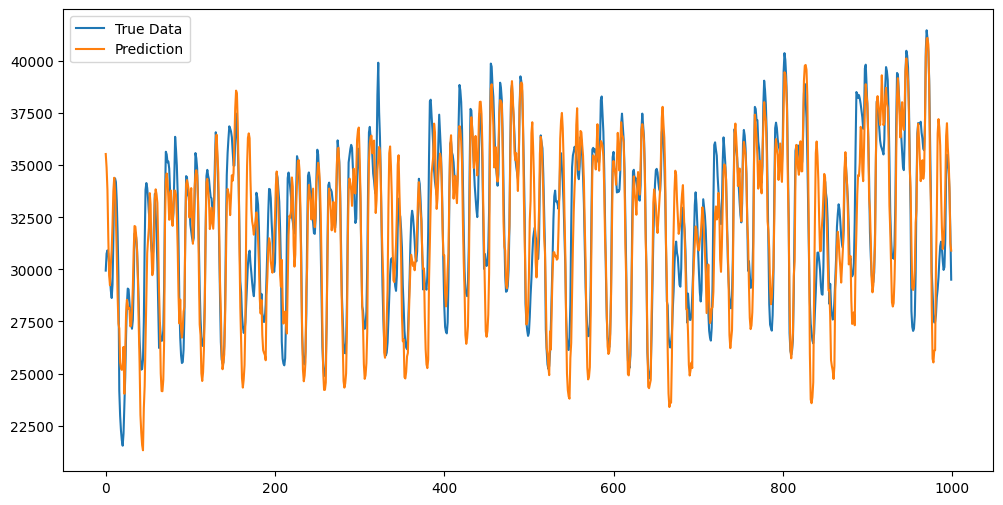

In [ ]:
test1(model_WLSTM,X_test,Y_test,data_df_combined_clean)

The mean square error is: 1429.956091
MAPE is: 4.717302


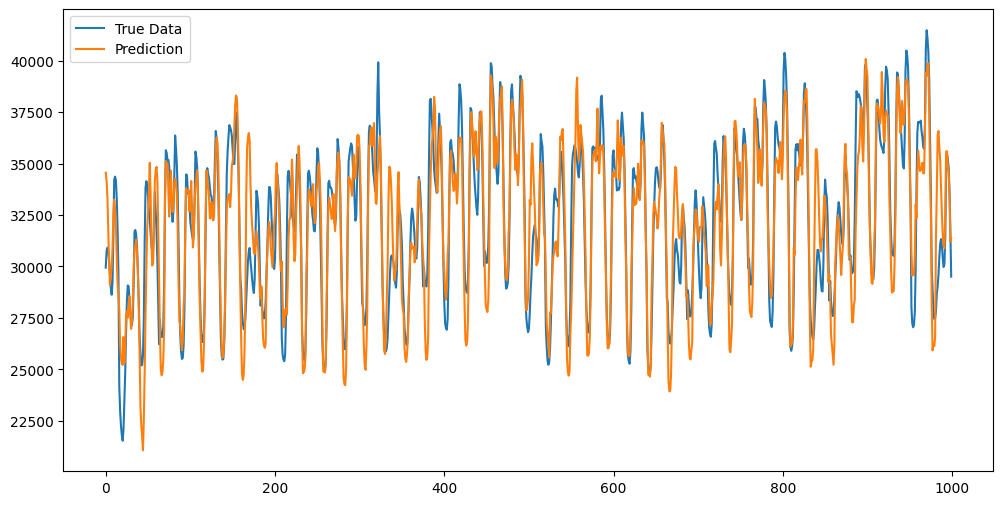

In [ ]:
test(model_WRNN,X_test,Y_test,data_df_combined_clean)

The mean square error is: 1511.993721
MAPE is: 5.062707


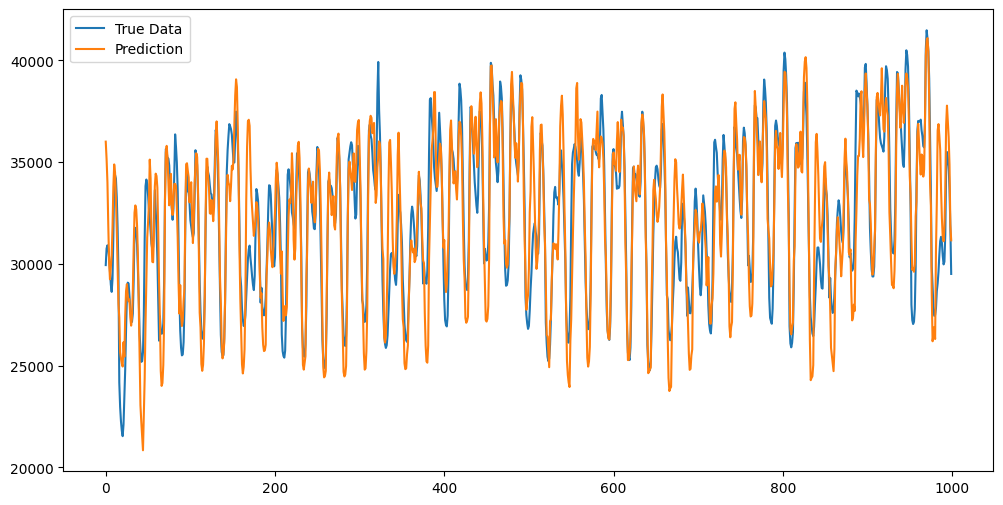

In [ ]:
test(model_WGRU,X_test,Y_test,data_df_combined_clean)

## Layers Importance spectra LSTM

> Indented block



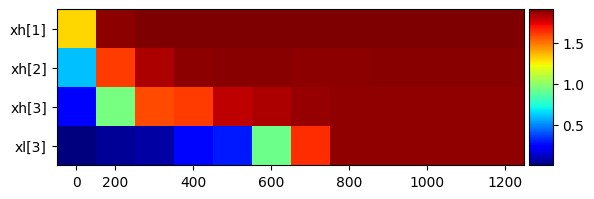

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np

model = Wavelet_LSTM(48, 100, 1, num_rnn_levels=3)
model_weights = model.state_dict()

xh1_weights = model_weights['mWDNs_H.0.weight']
xh2_weights = model_weights['mWDNs_H.1.weight']
xh3_weights = model_weights['mWDNs_H.2.weight']
xl3_weights = model_weights['mWDNs_L.2.weight']

xh1_importance = torch.abs(xh1_weights).sum(dim=0)
xh2_importance = torch.abs(xh2_weights).sum(dim=0)
xh3_importance = torch.abs(xh3_weights).sum(dim=0)
xl3_importance = torch.abs(xl3_weights).sum(dim=0)

min_length = min(len(xh1_importance), len(xh2_importance), len(xh3_importance), len(xl3_importance))

xh1_importance_resized = torch.nn.functional.interpolate(xh1_importance.unsqueeze(0).unsqueeze(0), size=min_length, mode='linear').squeeze()
xh2_importance_resized = torch.nn.functional.interpolate(xh2_importance.unsqueeze(0).unsqueeze(0), size=min_length, mode='linear').squeeze()
xh3_importance_resized = torch.nn.functional.interpolate(xh3_importance.unsqueeze(0).unsqueeze(0), size=min_length, mode='linear').squeeze()
xl3_importance_resized = torch.nn.functional.interpolate(xl3_importance.unsqueeze(0).unsqueeze(0), size=min_length, mode='linear').squeeze()

importances = [
    ('xh[1]', xh1_importance_resized),
    ('xh[2]', xh2_importance_resized),
    ('xh[3]', xh3_importance_resized),
    ('xl[3]', xl3_importance_resized)
]
importances_sorted = sorted(importances, key=lambda x: torch.sum(x[1]), reverse=False)

# Your code to compute and resize the importances

# Extract the numerical values from importances
importances_data = [importance[1].numpy() for importance in importances]

# Determine the number of layers and frequencies
num_layers = len(importances_data)
num_frequencies = len(importances_data[0])

# Create a figure and axes
fig, ax = plt.subplots()

# Plot the importance spectra
im = ax.imshow(importances_data, cmap='jet')

# Set the y-ticks and tick labels
yticks = range(num_layers)  # No need to add +1 for 'xl[3]'
yticklabels = [importance[0] for importance in importances]
ax.set_yticks(yticks)
ax.set_yticklabels(yticklabels)

# Set the x-ticks and tick labels
xticks = np.linspace(0, num_frequencies - 1, num=7, dtype=int)  # Adjust the number of x-ticks as desired
xticklabels = [str(i) for i in range(0, 1201, 200)]  # Generate labels from 0 to 120 with a step of 20
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)

# Create an Axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

# Add the colorbar
plt.colorbar(im, cax=cax)

plt.show()


## Layers Importance spectra RNN


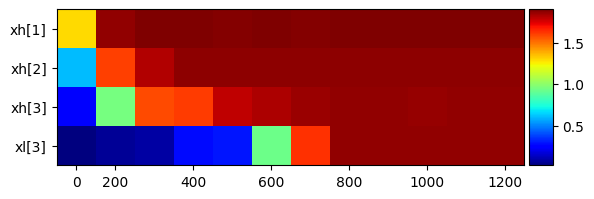

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np

model = Wavelet_RNN(48, 100, 1, num_rnn_levels=3)
model_weights = model.state_dict()

xh1_weights = model_weights['mWDNs_H.0.weight']
xh2_weights = model_weights['mWDNs_H.1.weight']
xh3_weights = model_weights['mWDNs_H.2.weight']
xl3_weights = model_weights['mWDNs_L.2.weight']

xh1_importance = torch.abs(xh1_weights).sum(dim=0)
xh2_importance = torch.abs(xh2_weights).sum(dim=0)
xh3_importance = torch.abs(xh3_weights).sum(dim=0)
xl3_importance = torch.abs(xl3_weights).sum(dim=0)

min_length = min(len(xh1_importance), len(xh2_importance), len(xh3_importance), len(xl3_importance))

xh1_importance_resized = torch.nn.functional.interpolate(xh1_importance.unsqueeze(0).unsqueeze(0), size=min_length, mode='linear').squeeze()
xh2_importance_resized = torch.nn.functional.interpolate(xh2_importance.unsqueeze(0).unsqueeze(0), size=min_length, mode='linear').squeeze()
xh3_importance_resized = torch.nn.functional.interpolate(xh3_importance.unsqueeze(0).unsqueeze(0), size=min_length, mode='linear').squeeze()
xl3_importance_resized = torch.nn.functional.interpolate(xl3_importance.unsqueeze(0).unsqueeze(0), size=min_length, mode='linear').squeeze()

importances = [
    ('xh[1]', xh1_importance_resized),
    ('xh[2]', xh2_importance_resized),
    ('xh[3]', xh3_importance_resized),
    ('xl[3]', xl3_importance_resized)
]
importances_sorted = sorted(importances, key=lambda x: torch.sum(x[1]), reverse=False)

# Your code to compute and resize the importances

# Extract the numerical values from importances
importances_data = [importance[1].numpy() for importance in importances]

# Determine the number of layers and frequencies
num_layers = len(importances_data)
num_frequencies = len(importances_data[0])

# Create a figure and axes
fig, ax = plt.subplots()

# Plot the importance spectra
im = ax.imshow(importances_data, cmap='jet')

# Set the y-ticks and tick labels
yticks = range(num_layers)  # No need to add +1 for 'xl[3]'
yticklabels = [importance[0] for importance in importances]
ax.set_yticks(yticks)
ax.set_yticklabels(yticklabels)

# Set the x-ticks and tick labels
xticks = np.linspace(0, num_frequencies - 1, num=7, dtype=int)  # Adjust the number of x-ticks as desired
xticklabels = [str(i) for i in range(0, 1201, 200)]  # Generate labels from 0 to 120 with a step of 20
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)

# Create an Axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

# Add the colorbar
plt.colorbar(im, cax=cax)

plt.show()


## Layers Importance spectra GRU


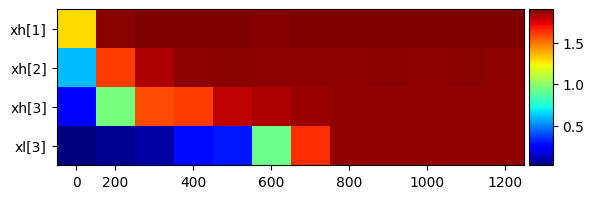

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np

model = Wavelet_RNN(48, 100, 1, num_rnn_levels=3)
model_weights = model.state_dict()

xh1_weights = model_weights['mWDNs_H.0.weight']
xh2_weights = model_weights['mWDNs_H.1.weight']
xh3_weights = model_weights['mWDNs_H.2.weight']
xl3_weights = model_weights['mWDNs_L.2.weight']

xh1_importance = torch.abs(xh1_weights).sum(dim=0)
xh2_importance = torch.abs(xh2_weights).sum(dim=0)
xh3_importance = torch.abs(xh3_weights).sum(dim=0)
xl3_importance = torch.abs(xl3_weights).sum(dim=0)

min_length = min(len(xh1_importance), len(xh2_importance), len(xh3_importance), len(xl3_importance))

xh1_importance_resized = torch.nn.functional.interpolate(xh1_importance.unsqueeze(0).unsqueeze(0), size=min_length, mode='linear').squeeze()
xh2_importance_resized = torch.nn.functional.interpolate(xh2_importance.unsqueeze(0).unsqueeze(0), size=min_length, mode='linear').squeeze()
xh3_importance_resized = torch.nn.functional.interpolate(xh3_importance.unsqueeze(0).unsqueeze(0), size=min_length, mode='linear').squeeze()
xl3_importance_resized = torch.nn.functional.interpolate(xl3_importance.unsqueeze(0).unsqueeze(0), size=min_length, mode='linear').squeeze()

importances = [
    ('xh[1]', xh1_importance_resized),
    ('xh[2]', xh2_importance_resized),
    ('xh[3]', xh3_importance_resized),
    ('xl[3]', xl3_importance_resized)
]
importances_sorted = sorted(importances, key=lambda x: torch.sum(x[1]), reverse=False)

# Your code to compute and resize the importances

# Extract the numerical values from importances
importances_data = [importance[1].numpy() for importance in importances]

# Determine the number of layers and frequencies
num_layers = len(importances_data)
num_frequencies = len(importances_data[0])

# Create a figure and axes
fig, ax = plt.subplots()

# Plot the importance spectra
im = ax.imshow(importances_data, cmap='jet')

# Set the y-ticks and tick labels
yticks = range(num_layers)  # No need to add +1 for 'xl[3]'
yticklabels = [importance[0] for importance in importances]
ax.set_yticks(yticks)
ax.set_yticklabels(yticklabels)

# Set the x-ticks and tick labels
xticks = np.linspace(0, num_frequencies - 1, num=7, dtype=int)  # Adjust the number of x-ticks as desired
xticklabels = [str(i) for i in range(0, 1201, 200)]  # Generate labels from 0 to 120 with a step of 20
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)

# Create an Axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

# Add the colorbar
plt.colorbar(im, cax=cax)

plt.show()


## Grid search

In [ ]:
data_path = '/content/drive/MyDrive/PJM_Load_hourly.csv'
P = 24  # sequence length
step = 6  # ahead predict steps

X_train, Y_train, X_test, Y_test, data_df_combined_clean = load_data(data_path, P=P, step=step)

# Define the range of num_rnn_levels values to search
num_rnn_levels_values = [1, 2, 3, 4]

best_model = None
best_mape = float('inf')

for num_rnn_levels in num_rnn_levels_values:
    model = Wavelet_LSTM(P, 100, 1, num_rnn_levels=num_rnn_levels)
    model = model.double()


    train1(model, X_train, Y_train, epochs=10)

    model.eval()
    x_test = ToVariable(X_test).double() # Convert x_test to PyTorch tensor
    hidden_states = model.init_state(x_test.shape[0])

    pred_dat, hidden_states = model(x_test, hidden_states)

    pred_dat = np.array(pred_dat.detach().numpy())

    # De-standardize predictions
    preds_unstd = pred_dat * data_df_combined_clean.iloc[:, -1].std() + data_df_combined_clean.iloc[:, -1].mean()
    y_test_unstd = Y_test * data_df_combined_clean.iloc[:, -1].std() + data_df_combined_clean.iloc[:, -1].mean()

    mrse = np.sqrt(((preds_unstd[:, -1, :] - y_test_unstd[:, -1, :]) ** 2)).mean(axis=0)
    print('The mean square error is: %f' % mrse)
    mape = np.mean(np.abs((y_test_unstd[:, -1, :] - preds_unstd[:, -1, :]) / y_test_unstd[:, -1, :])) * 100
    print('MAPE is: %f' % mape)
    #print('MAPE is: %f' % mape)

    # Check if the current model has better performance than the previous best model
    if mape < best_mape:
        best_model = model
        best_mape = mape

print("Best num_rnn_levels:", best_model.num_rnn_levels)

Epoch: 1 | Batch: 822 | Loss: 1.4412516966431077
Epoch: 2 | Batch: 822 | Loss: 0.8848776688327886
Epoch: 3 | Batch: 822 | Loss: 0.16334069028562315
Epoch: 4 | Batch: 822 | Loss: 0.17328414636781858
Epoch: 5 | Batch: 822 | Loss: 0.11420048390648813
Epoch: 6 | Batch: 822 | Loss: 0.1865910640365608
Epoch: 7 | Batch: 822 | Loss: 0.23776090449584575
Epoch: 8 | Batch: 822 | Loss: 0.14260977502859695
Epoch: 9 | Batch: 822 | Loss: 0.09912360889651678
Epoch: 10 | Batch: 822 | Loss: 0.08898319619905475
The mean square error is: 1831.813790
MAPE is: 6.024406
Epoch: 1 | Batch: 822 | Loss: 1.7554092374804624
Epoch: 2 | Batch: 822 | Loss: 1.2116964507659538
Epoch: 3 | Batch: 822 | Loss: 0.9008681806326558
Epoch: 4 | Batch: 822 | Loss: 1.7747122578391106
Epoch: 5 | Batch: 822 | Loss: 1.1672809196406269
Epoch: 6 | Batch: 822 | Loss: 1.136619517541019
Epoch: 7 | Batch: 822 | Loss: 1.1184468293668417
Epoch: 8 | Batch: 822 | Loss: 0.6906195733668944
Epoch: 9 | Batch: 822 | Loss: 0.8992599744082684
Epoch:

## Comparison

In [ ]:
data_path = '/content/drive/MyDrive/PJM_Load_hourly.csv'

# Define the range of period lengths to compare
period_lengths = [12, 24, 48, 72, 96]

best_model = None
best_mape = float('inf')
mape_values1=[]
mape_errors1 = []

for period_length in period_lengths:
    # Load the data with the current period length
    P = period_length  # sequence length
    step = 6  # ahead predict steps

    X_train, Y_train, X_test, Y_test, data_df_combined_clean = load_data(data_path, P=P, step=step)

    # Create and train the model with the current period length
    model = Wavelet_LSTM(P, 100, 1, num_rnn_levels=2)
    model = model.double()
    #X_train = torch.from_numpy(X_train)
    #Y_train = torch.from_numpy(Y_train)
    train1(model, X_train, Y_train, epochs=10)

    model.eval()
    x_test = ToVariable(X_test).double() # Convert x_test to PyTorch tensor
    hidden_states = model.init_state(x_test.shape[0])

    pred_dat, hidden_states = model(x_test, hidden_states)

    pred_dat = np.array(pred_dat.detach().numpy())

    # De-standardize predictions
    preds_unstd = pred_dat * data_df_combined_clean.iloc[:, -1].std() + data_df_combined_clean.iloc[:, -1].mean()
    y_test_unstd = Y_test * data_df_combined_clean.iloc[:, -1].std() + data_df_combined_clean.iloc[:, -1].mean()

    mrse = np.sqrt(((preds_unstd[:, -1, :] - y_test_unstd[:, -1, :]) ** 2)).mean(axis=0)
    mape = np.mean(np.abs((y_test_unstd[:, -1, :] - preds_unstd[:, -1, :]) / y_test_unstd[:, -1, :])) * 100

    mape_values1.append(mape)
    mape_std = np.std(mape)
    mape_errors1.append(mape_std)

    print('MAPE for period length {}: {}'.format(period_length, mape))

Epoch: 1 | Batch: 822 | Loss: 0.9500648458811769
Epoch: 2 | Batch: 822 | Loss: 0.7994509907536115
Epoch: 3 | Batch: 822 | Loss: 1.1897641268846972
Epoch: 4 | Batch: 822 | Loss: 1.0746271855608858
Epoch: 5 | Batch: 822 | Loss: 1.3824315941449885
Epoch: 6 | Batch: 822 | Loss: 0.6160981646140185
Epoch: 7 | Batch: 822 | Loss: 0.7007797530251414
Epoch: 8 | Batch: 822 | Loss: 0.5816875773274485
Epoch: 9 | Batch: 822 | Loss: 0.9898482897260752
Epoch: 10 | Batch: 822 | Loss: 1.0036385224328928
MAPE for period length 12: 15.592832260910395
Epoch: 1 | Batch: 822 | Loss: 1.0446094217492532
Epoch: 2 | Batch: 822 | Loss: 1.112331339187201
Epoch: 3 | Batch: 822 | Loss: 0.9378113509148949
Epoch: 4 | Batch: 822 | Loss: 1.1165885499822543
Epoch: 5 | Batch: 822 | Loss: 0.949541929583192
Epoch: 6 | Batch: 822 | Loss: 1.200476595303167
Epoch: 7 | Batch: 822 | Loss: 1.3060580898087997
Epoch: 8 | Batch: 822 | Loss: 1.1830269522030934
Epoch: 9 | Batch: 822 | Loss: 0.7456456577895154
Epoch: 10 | Batch: 822 | 

In [ ]:
# Define the range of period lengths to compare
period_lengths = [12, 24, 48, 72, 96]

best_model = None
best_mape = float('inf')
mape_values2=[]
mape_errors2= []

for period_length in period_lengths:
    # Load the data with the current period length
    P = period_length  # sequence length
    step = 6  # ahead predict steps

    X_train, Y_train, X_test, Y_test, data_df_combined_clean = load_data(data_path, P=P, step=step)

    # Create and train the model with the current period length
    model = Wavelet_RNN(P, 100, 1, num_rnn_levels=2)
    model = model.double()
    #X_train = torch.from_numpy(X_train)
    #Y_train = torch.from_numpy(Y_train)
    train(model, X_train, Y_train, epochs=10)

    model.eval()
    x_test = ToVariable(X_test).double()
    hiddens_states = model.init_state(x_test.shape[0])

    pred_dat = model(x_test, hiddens_states)

    pred_dat = np.array(pred_dat.detach().numpy())

    # De-standardize predictions
    preds_unstd = pred_dat * data_df_combined_clean.iloc[:, -1].std() + data_df_combined_clean.iloc[:, -1].mean()
    y_test_unstd = Y_test * data_df_combined_clean.iloc[:, -1].std() + data_df_combined_clean.iloc[:, -1].mean()

    mrse = np.sqrt(((preds_unstd[:, -1, :] - y_test_unstd[:, -1, :]) ** 2)).mean(axis=0)
    mape = np.mean(np.abs((y_test_unstd[:, -1, :] - preds_unstd[:, -1, :]) / y_test_unstd[:, -1, :])) * 100


    mape_values2.append(mape)
    mape_std = np.std(mape)
    mape_errors2.append(mape_std)

    print('MAPE for period length {}: {}'.format(period_length, mape))

Epoch: 1 | Batch: 822 | Loss: 1.153169144069771
Epoch: 2 | Batch: 822 | Loss: 0.6056731794315694
Epoch: 3 | Batch: 822 | Loss: 0.824893838026407
Epoch: 4 | Batch: 822 | Loss: 0.7845490759069071
Epoch: 5 | Batch: 822 | Loss: 0.965154675104382
Epoch: 6 | Batch: 822 | Loss: 0.5092426159280536
Epoch: 7 | Batch: 822 | Loss: 0.8793859751396363
Epoch: 8 | Batch: 822 | Loss: 0.5815003538619545
Epoch: 9 | Batch: 822 | Loss: 0.8286912814884658
Epoch: 10 | Batch: 822 | Loss: 0.6359125370133528
MAPE for period length 12: 14.374281084181728
Epoch: 1 | Batch: 822 | Loss: 0.26233405759205547
Epoch: 2 | Batch: 822 | Loss: 0.40150808075799954
Epoch: 3 | Batch: 822 | Loss: 0.3003169181486705
Epoch: 4 | Batch: 822 | Loss: 0.09130109019302565
Epoch: 5 | Batch: 822 | Loss: 0.21847421991244315
Epoch: 6 | Batch: 822 | Loss: 0.12783350680554834
Epoch: 7 | Batch: 822 | Loss: 0.07413206208107356
Epoch: 8 | Batch: 822 | Loss: 0.0929066397860736
Epoch: 9 | Batch: 822 | Loss: 0.08414565500904068
Epoch: 10 | Batch:

In [ ]:
# Define the range of period lengths to compare
period_lengths = [12, 24, 48, 72, 96]

best_model = None
best_mape = float('inf')
mape_values3=[]
mape_errors3 = []

for period_length in period_lengths:
    # Load the data with the current period length
    P = period_length  # sequence length
    step = 6  # ahead predict steps

    X_train, Y_train, X_test, Y_test, data_df_combined_clean = load_data(data_path, P=P, step=step)

    # Create and train the model with the current period length
    model = Wavelet_GRU(P, 100, 1, num_rnn_levels=2)
    model = model.double()
    #X_train = torch.from_numpy(X_train)
    #Y_train = torch.from_numpy(Y_train)
    train(model, X_train, Y_train, epochs=10)

    model.eval()
    x_test = ToVariable(X_test).double()
    hiddens_states = model.init_state(x_test.shape[0])

    pred_dat = model(x_test, hiddens_states)

    pred_dat = np.array(pred_dat.detach().numpy())

    # De-standardize predictions
    preds_unstd = pred_dat * data_df_combined_clean.iloc[:, -1].std() + data_df_combined_clean.iloc[:, -1].mean()
    y_test_unstd = Y_test * data_df_combined_clean.iloc[:, -1].std() + data_df_combined_clean.iloc[:, -1].mean()

    mrse = np.sqrt(((preds_unstd[:, -1, :] - y_test_unstd[:, -1, :]) ** 2)).mean(axis=0)
    mape = np.mean(np.abs((y_test_unstd[:, -1, :] - preds_unstd[:, -1, :]) / y_test_unstd[:, -1, :])) * 100

    mape_values3.append(mape)
    mape_std = np.std(mape)
    mape_errors3.append(mape_std)

    print('MAPE for period length {}: {}'.format(period_length, mape))

Epoch: 1 | Batch: 822 | Loss: 1.1328734970682548
Epoch: 2 | Batch: 822 | Loss: 0.7511549198060903
Epoch: 3 | Batch: 822 | Loss: 1.5781441000027232
Epoch: 4 | Batch: 822 | Loss: 0.8861448186793139
Epoch: 5 | Batch: 822 | Loss: 1.0227601565423996
Epoch: 6 | Batch: 822 | Loss: 0.9565502968970047
Epoch: 7 | Batch: 822 | Loss: 0.6989644124598091
Epoch: 8 | Batch: 822 | Loss: 0.6354085618206728
Epoch: 9 | Batch: 822 | Loss: 0.6673390019124961
Epoch: 10 | Batch: 822 | Loss: 0.6416315479444098
MAPE for period length 12: 14.455854957354857
Epoch: 1 | Batch: 822 | Loss: 1.2839499581493028
Epoch: 2 | Batch: 822 | Loss: 0.4421466446804047
Epoch: 3 | Batch: 822 | Loss: 0.3574676107614287
Epoch: 4 | Batch: 822 | Loss: 0.2415895655834797
Epoch: 5 | Batch: 822 | Loss: 0.1290534497692662
Epoch: 6 | Batch: 822 | Loss: 0.1221967040813099
Epoch: 7 | Batch: 822 | Loss: 0.09711607024097078
Epoch: 8 | Batch: 822 | Loss: 0.050318897590956285
Epoch: 9 | Batch: 822 | Loss: 0.1214176554795535
Epoch: 10 | Batch: 

In [ ]:
#Metrics of non wavelet models
mape_values4 = [18.277176, 14.559941, 16.226897, 16.360245, 16.723757]
mape_values5 = [16.831634, 16.635590, 16.441804, 16.468287, 16.782278]
mape_values6 = [17.943755, 17.558939, 17.172863, 17.527546, 16.951187]
mape_errors4 = []
mape_errors5 = []
mape_errors6 = []
for i in mape_values4:
  mape_std = np.std(i)
  mape_errors4.append(mape_std)

for i in mape_values5:
  mape_std = np.std(i)
  mape_errors5.append(mape_std)

for i in mape_values6:
  mape_std = np.std(i)
  mape_errors6.append(mape_std)

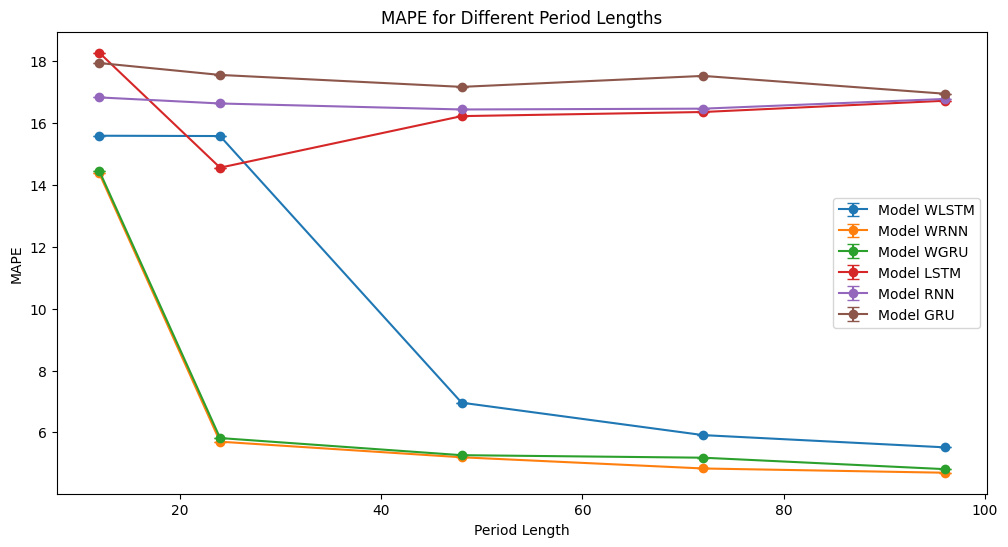

In [ ]:
import matplotlib.pyplot as plt

# Existing code for model evaluation and obtaining mape_values and mape_errors

# Plotting
fig = plt.figure(facecolor='white', figsize=(12, 6))
plt.errorbar(period_lengths, mape_values1, yerr=mape_errors1, fmt='o-', capsize=4, label='Model WLSTM')
plt.errorbar(period_lengths, mape_values2, yerr=mape_errors2, fmt='o-', capsize=4, label='Model WRNN')
plt.errorbar(period_lengths, mape_values3, yerr=mape_errors3, fmt='o-', capsize=4, label='Model WGRU')
plt.errorbar(period_lengths, mape_values4, yerr=mape_errors4, fmt='o-', capsize=4, label='Model LSTM')
plt.errorbar(period_lengths, mape_values5, yerr=mape_errors5, fmt='o-', capsize=4, label='Model RNN')
plt.errorbar(period_lengths, mape_values6, yerr=mape_errors6, fmt='o-', capsize=4, label='Model GRU')

plt.xlabel('Period Length')
plt.ylabel('MAPE')
plt.title('MAPE for Different Period Lengths')

plt.legend()
plt.show()


## Transformer model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class TransformerModel(nn.Module):
    def __init__(self, input_dim, output_dim, num_heads, hidden_dim, num_layers, dropout):
        super(TransformerModel, self).__init__()

        self.embedding = nn.Linear(input_dim, hidden_dim)
        self.positional_encoding = self._generate_positional_encoding(hidden_dim)
        self.positional_encoding = self.positional_encoding.to(device)  # Move positional_encoding to device

        self.transformer_layers = nn.ModuleList([
            TransformerEncoderLayer(hidden_dim, num_heads, hidden_dim * 4, dropout)
            for _ in range(num_layers)
        ])
        self.fc = nn.Linear(hidden_dim, output_dim * output_sequence_length)  # Modify the output dimension

    def forward(self, x):
        x = self.embedding(x) + self.positional_encoding[:x.size(1), :]
        for layer in self.transformer_layers:
            x = layer(x)
        x = self.fc(x[:, -1, :])
        x = x.view(x.size(0), output_sequence_length, -1)  # Reshape to (batch_size, output_sequence_length, output_dim)

        return x

    def _generate_positional_encoding(self, hidden_dim):
        position = torch.arange(0, 1000).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, hidden_dim, 2) * (-torch.log(torch.tensor(10000.0)) / hidden_dim))
        positional_encoding = torch.zeros(1000, hidden_dim)
        positional_encoding[:, 0::2] = torch.sin(position * div_term)
        positional_encoding[:, 1::2] = torch.cos(position * div_term)
        return positional_encoding

class TransformerEncoderLayer(nn.Module):
    def __init__(self, hidden_dim, num_heads, feed_forward_dim, dropout):
        super(TransformerEncoderLayer, self).__init__()
        self.attention = nn.MultiheadAttention(hidden_dim, num_heads, dropout=dropout)
        self.feed_forward = nn.Sequential(
            nn.Linear(hidden_dim, feed_forward_dim),
            nn.ReLU(),
            nn.Linear(feed_forward_dim, hidden_dim)
        )
        self.layer_norm1 = nn.LayerNorm(hidden_dim)
        self.layer_norm2 = nn.LayerNorm(hidden_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        residual = x
        x = self.layer_norm1(x)
        x, _ = self.attention(x, x, x)
        x = self.dropout(x)
        x = x + residual

        residual = x
        x = self.layer_norm2(x)
        x = self.feed_forward(x)
        x = self.dropout(x)
        x = x + residual

        return x


In [ ]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import h5py
from torch.utils.data import DataLoader, Dataset
from torch.autograd import Variable
import pywt

def ToVariable(x):
    # use in train.py
    # change from numpy.array to torch.variable
    tmp = torch.DoubleTensor(x)
    return Variable(tmp)

class Wavelet_Transformer(nn.Module):
    def __init__(self, input_dim, output_dim, seq_len, hidden_size, output_size, num_heads, num_layers, dropout=0.1):
        super(Wavelet_Transformer, self).__init__()

        self.seq_len = seq_len
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_heads = num_heads
        self.num_layers = num_layers
        self.input_dim = input_dim
        self.output_dim = output_dim

        self.transformer_xh1 = TransformerModel(1, output_dim, num_heads, hidden_dim, num_layers, dropout)
        self.transformer_xh2 = TransformerModel(1, output_dim, num_heads, hidden_dim, num_layers, dropout)
        self.transformer_xh3 = TransformerModel(1, output_dim, num_heads, hidden_dim, num_layers, dropout)
        self.transformer_xl3 = TransformerModel(1, output_dim, num_heads, hidden_dim, num_layers, dropout)

        self.mWDN1_H = nn.Linear(seq_len, seq_len)
        self.mWDN1_L = nn.Linear(seq_len, seq_len)
        self.mWDN2_H = nn.Linear(int(seq_len / 2), int(seq_len / 2))
        self.mWDN2_L = nn.Linear(int(seq_len / 2), int(seq_len / 2))
        self.mWDN3_H = nn.Linear(int(seq_len / 4), int(seq_len / 4))
        self.mWDN3_L = nn.Linear(int(seq_len / 4), int(seq_len / 4))

        self.a_to_x = nn.AvgPool1d(2)
        self.sigmoid = nn.Sigmoid()


        self.output = nn.Linear(hidden_size, output_size)

        wavelet = pywt.Wavelet('db4')
        low = wavelet.dec_lo
        high = wavelet.dec_hi
        self.l_filter = low
        self.h_filter = high

        self.cmp_mWDN1_H = ToVariable(self.create_W(seq_len,False,is_comp=True))
        self.cmp_mWDN1_L = ToVariable(self.create_W(seq_len,True,is_comp=True))
        self.cmp_mWDN2_H = ToVariable(self.create_W(int(seq_len/2),False,is_comp=True))
        self.cmp_mWDN2_L = ToVariable(self.create_W(int(seq_len/2),True,is_comp=True))
        self.cmp_mWDN3_H = ToVariable(self.create_W(int(seq_len/4),False,is_comp=True))
        self.cmp_mWDN3_L = ToVariable(self.create_W(int(seq_len/4),True,is_comp=True))

        self.mWDN1_H.weight = torch.nn.Parameter(ToVariable(self.create_W(seq_len,False)))
        self.mWDN1_L.weight = torch.nn.Parameter(ToVariable(self.create_W(seq_len,True)))
        self.mWDN2_H.weight = torch.nn.Parameter(ToVariable(self.create_W(int(seq_len/2),False)))
        self.mWDN2_L.weight = torch.nn.Parameter(ToVariable(self.create_W(int(seq_len/2),True)))
        self.mWDN3_H.weight = torch.nn.Parameter(ToVariable(self.create_W(int(seq_len/4),False)))
        self.mWDN3_L.weight = torch.nn.Parameter(ToVariable(self.create_W(int(seq_len/4),True)))

        self.mWDN1_H = nn.Linear(seq_len, seq_len).to(input.dtype)
        self.mWDN1_L = nn.Linear(seq_len, seq_len).to(input.dtype)
        self.mWDN2_H = nn.Linear((int(seq_len/2)), (int(seq_len/2))).to(input.dtype)
        self.mWDN2_L = nn.Linear((int(seq_len/2)), (int(seq_len/2))).to(input.dtype)
        self.mWDN3_H = nn.Linear((int(seq_len/4)), (int(seq_len/4))).to(input.dtype)
        self.mWDN3_L = nn.Linear((int(seq_len/4)), (int(seq_len/4))).to(input.dtype)


        self.output = nn.Linear(4, output_size)

    def forward(self, input):

        input = input.view(input.shape[0], input.shape[1])
        ah_1 = self.sigmoid(self.mWDN1_H(input))
        al_1 = self.sigmoid(self.mWDN1_L(input))
        xh_1 = self.a_to_x(ah_1.view(ah_1.shape[0], 1, -1))
        xl_1 = self.a_to_x(al_1.view(al_1.shape[0], 1, -1))

        ah_2 = self.sigmoid(self.mWDN2_H(xl_1))
        al_2 = self.sigmoid(self.mWDN2_L(xl_1))

        xh_2 = self.a_to_x(ah_2)
        xl_2 = self.a_to_x(al_2)

        ah_3 = self.sigmoid(self.mWDN3_H(xl_2))
        al_3 = self.sigmoid(self.mWDN3_L(xl_2))

        xh_3 = self.a_to_x(ah_3)
        xl_3 = self.a_to_x(al_3)

        xh_1 = xh_1.transpose(1, 2)
        xh_2 = xh_2.transpose(1, 2)
        xh_3 = xh_3.transpose(1, 2)
        xl_3 = xl_3.transpose(1, 2)


        level1_transformer = self.transformer_xh1(xh_1)
        level2_transformer = self.transformer_xh2(xh_2)
        level3_transformer = self.transformer_xh3(xh_3)
        level4_transformer = self.transformer_xl3(xl_3)


        output = torch.cat((level1_transformer, level2_transformer, level3_transformer, level4_transformer), 2)

        output = self.output(output) # Adjust the output tensor dimensions
        return output

    def create_W(self, P, is_l, is_comp=False):
        if is_l:
            filter_list = self.l_filter
        else:
            filter_list = self.h_filter

        list_len = len(filter_list)

        max_epsilon = np.min(np.abs(filter_list))
        if is_comp:
            weight_np = np.zeros((P, P))
        else:
            weight_np = np.random.randn(P, P) * 0.1 * max_epsilon

        for i in range(0, P):
            filter_index = 0
            for j in range(i, P):
                if filter_index < len(filter_list):
                    weight_np[i][j] = filter_list[filter_index]
                    filter_index += 1
        return weight_np


## experiment

In [ ]:
EPOCHS = 50
LEARNING_RATE = 0.0001
device = 'cuda' if torch.cuda.is_available() else 'cpu'

input_dim = training_data[0][0].shape[-1]  # Dimensionality of input sequence
output_dim = 1  # Dimensionality of output (load forecast)
num_heads = 4  # Number of attention heads
hidden_dim = 64  # Hidden dimension of the Transformer model
num_layers = 2  # Number of Transformer encoder layers
dropout = 0.1  # Dropout rate


model = TransformerModel(input_dim, output_dim, num_heads, hidden_dim, num_layers, dropout)
criterion = torch.nn.MSELoss()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

In [ ]:
early_stopping_patience = 150
early_stopping_counter = 0

train_loss = []
val_loss = []

for epoch in range(EPOCHS):
    model.train()
    epoch_train_loss = 0.0  # Initialize epoch_train_loss

    for i, (input, output) in enumerate(training_data_load):
        input = input.to(device)
        output = output.to(device)
        optimizer.zero_grad()
        pred = model(input)
        loss_tr = criterion(pred, output)
        loss_tr.backward()
        optimizer.step()

        epoch_train_loss += loss_tr.item()

    train_loss.append(epoch_train_loss / len(training_data_load))  # Append average training loss per epoch

    model.eval()
    with torch.no_grad():
        epoch_val_loss = 0.0

        for i, (input, output) in enumerate(validation_data_load):
            input = input.to(device)
            output = output.to(device)

            pred = model(input)
            loss_val = criterion(pred, output)

            epoch_val_loss += loss_val.item()

        val_loss.append(epoch_val_loss / len(validation_data_load))  # Append average validation loss per epoch

        print(f"Epoch {epoch} -->  Train Loss: {train_loss[-1]}, Val Loss: {val_loss[-1]}")


Epoch 0 -->  Train Loss: 1.0252273850716078, Val Loss: 0.9136903796877179
Epoch 1 -->  Train Loss: 0.6812426000833511, Val Loss: 0.6905023796217782
Epoch 2 -->  Train Loss: 0.5438775511888357, Val Loss: 0.5923627657549722
Epoch 3 -->  Train Loss: 0.49211462988303256, Val Loss: 0.5558080971240997
Epoch 4 -->  Train Loss: 0.4726056754589081, Val Loss: 0.5367192029953003
Epoch 5 -->  Train Loss: 0.46136109416301435, Val Loss: 0.5240387618541718
Epoch 6 -->  Train Loss: 0.4537449043530684, Val Loss: 0.515340975352696
Epoch 7 -->  Train Loss: 0.44843971041532665, Val Loss: 0.5091851609093803
Epoch 8 -->  Train Loss: 0.4445921079470561, Val Loss: 0.5046666647706713
Epoch 9 -->  Train Loss: 0.4419268106038754, Val Loss: 0.5011352854115623
Epoch 10 -->  Train Loss: 0.4392562714906839, Val Loss: 0.49840408137866427
Epoch 11 -->  Train Loss: 0.4377031555542579, Val Loss: 0.4960947164467403
Epoch 12 -->  Train Loss: 0.43579221688784087, Val Loss: 0.49415156670979093
Epoch 13 -->  Train Loss: 0.43

In [ ]:
#RMSE MAPE
def RMSE(predictions, targets):
    return torch.sqrt(torch.mean((predictions - targets)**2))

def MAPE(predictions, targets):
    return torch.mean(torch.abs((targets - predictions) / targets)*100)

def Average(lst):
    return sum(lst) / len(lst)

In [ ]:
#for test set
RMSE_result_test=[]
MAPE_result_test=[]

model.to(device)
model.eval()
with torch.no_grad():
  for i, (input ,output) in enumerate(validation_data_load):   # validation_dataloader


      input=input.to(device)
      output=output.to(device)


      prediction1 = model(input)

      #use inverse of scaler that we used for normalization for both y_true and prediction
      prediction1=scaler_E.inverse_transform(prediction1.detach().cpu().numpy().squeeze(-1))
      prediction1=torch.tensor(prediction1)
      prediction1=prediction1.unsqueeze(-1).to(device)

      output=scaler_E.inverse_transform(output.detach().cpu().numpy().squeeze(-1))
      output=torch.tensor(output)
      output=output.unsqueeze(-1).to(device)

      #loss_test = torch.sqrt(criterion(tgt_y, prediction))
      RMSE_test = RMSE(prediction1,output)
      MAPE_test = MAPE(prediction1,output)

      RMSE_result_test.append(RMSE_test.item())
      MAPE_result_test.append(MAPE_test.item())

In [ ]:

RMSE_avg=Average(RMSE_result_test)
MAPE_avg= Average(MAPE_result_test)
print('The mean square error is: %f' % RMSE_avg)
print('MAPE is: %f' % MAPE_avg)

The mean square error is: 3884.071638
MAPE is: 10.447467


In [ ]:
predictions=np.array(prediction1.detach().cpu().numpy())
outputs = np.array(output.detach().cpu().numpy())
pred = predictions[:,-1,:]
out = outputs[:,-1,:]

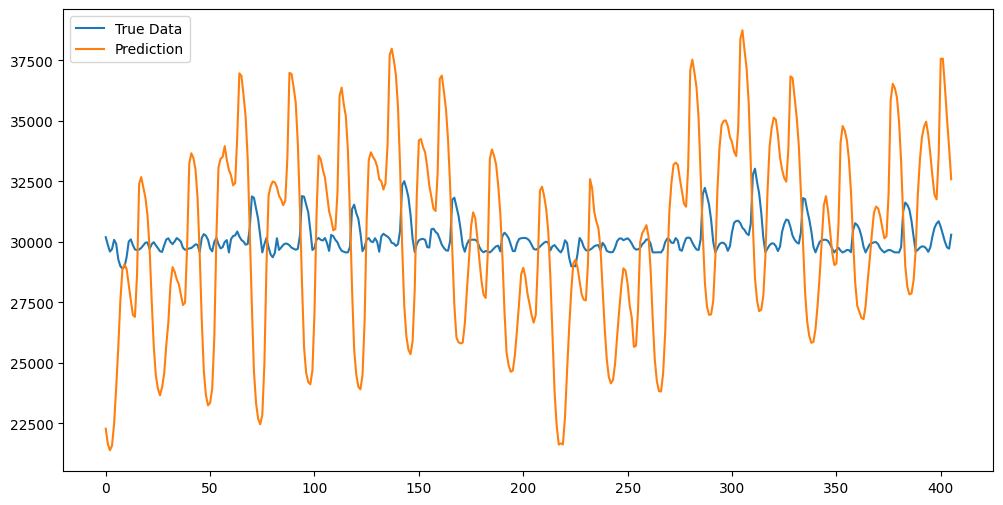

In [ ]:
fig = plt.figure(facecolor='white', figsize=(12, 6))
ax = fig.add_subplot(111)
ax.plot(pred[-1000:], label='True Data')
plt.plot(out[-1000:], label='Prediction')
plt.legend()
plt.show()

In [ ]:
##Wavlet Transformer Model

EPOCHS = 50
LEARNING_RATE = 0.0001
device = 'cuda' if torch.cuda.is_available() else 'cpu'


input_dim = input_seq_len
output_dim = 1
seq_len = input_seq_len
input_dim = training_data[0][0].shape[-1]  # Dimensionality of input sequence
output_size = 1  # Dimensionality of output (load forecast)
num_heads = 4  # Number of attention heads
hidden_size = 64  # Hidden dimension of the Transformer model
num_layers = 2  # Number of Transformer encoder layers
dropout = 0.1  # Dropout rate
hidden_dim = 64

modelw = Wavelet_Transformer(input_dim, output_dim, seq_len, hidden_size, output_size, num_heads, num_layers)
criterion = torch.nn.MSELoss()
modelw.to(device)
optimizer = torch.optim.Adam(modelw.parameters(), lr = LEARNING_RATE)

In [ ]:
early_stopping_patience = 150
early_stopping_counter = 0

train_loss = []
val_loss = []

for epoch in range(EPOCHS):
    modelw.train()
    epoch_train_loss = 0.0  # Initialize epoch_train_loss

    for i, (input, output) in enumerate(training_data_load):
        input = input.to(device)
        output = output.to(device)
        optimizer.zero_grad()

        pred = modelw(input)
        #loss_tr = criterion(pred, output)
        loss_tr = criterion(pred[:,-1,:], output[:,-1,:])
        loss_tr.backward()
        optimizer.step()

        epoch_train_loss += loss_tr.item()

    train_loss.append(epoch_train_loss / len(training_data_load))  # Append average training loss per epoch

    modelw.eval()
    with torch.no_grad():
        epoch_val_loss = 0.0

        for i, (input, output) in enumerate(validation_data_load):
            input = input.to(device)
            output = output.to(device)

            pred = modelw(input)
            loss_val = criterion(pred[:,-1,:], output[:,-1,:])

            epoch_val_loss += loss_val.item()

        val_loss.append(epoch_val_loss / len(validation_data_load))  # Append average validation loss per epoch

        print(f"Epoch {epoch} -->  Train Loss: {train_loss[-1]}, Val Loss: {val_loss[-1]}")


Epoch 0 -->  Train Loss: 1.0315140749399478, Val Loss: 1.1915122994354792
Epoch 1 -->  Train Loss: 1.023016060774143, Val Loss: 1.165502403463636
Epoch 2 -->  Train Loss: 1.0024917125701904, Val Loss: 1.1408713502543313
Epoch 3 -->  Train Loss: 0.9732519330886694, Val Loss: 1.1000204724924905
Epoch 4 -->  Train Loss: 0.9278353257821157, Val Loss: 1.022890874317714
Epoch 5 -->  Train Loss: 0.8349913622324283, Val Loss: 0.8708145661013467
Epoch 6 -->  Train Loss: 0.6701449694541785, Val Loss: 0.6734187517847333
Epoch 7 -->  Train Loss: 0.5187132415863184, Val Loss: 0.5537104053156716
Epoch 8 -->  Train Loss: 0.43368030339479446, Val Loss: 0.48154184009347645
Epoch 9 -->  Train Loss: 0.38282749916498476, Val Loss: 0.438168323465756
Epoch 10 -->  Train Loss: 0.358105155137869, Val Loss: 0.4102311836821692
Epoch 11 -->  Train Loss: 0.34139637133249867, Val Loss: 0.3919060102530888
Epoch 12 -->  Train Loss: 0.3286761303360646, Val Loss: 0.37698821084839956
Epoch 13 -->  Train Loss: 0.3175888

In [ ]:
#RMSE MAPE
def RMSE(predictions, targets):
    return torch.sqrt(torch.mean((predictions - targets)**2))

def MAPE(predictions, targets):
    return torch.mean(torch.abs((targets - predictions) / targets)*100)

def Average(lst):
    return sum(lst) / len(lst)

In [ ]:
RMSE_result_test = []
MAPE_result_test = []

modelw.to(device)
modelw.eval()
with torch.no_grad():
    for i, (input, output) in enumerate(validation_data_load):
        input = input.to(device)
        output = output.to(device)

        prediction = modelw(input)

        # Use inverse of scaler that we used for normalization for both y_true and prediction
        prediction = scaler_E.inverse_transform(prediction.detach().cpu().numpy().squeeze(-1))
        prediction = torch.tensor(prediction).to(device)
        prediction = prediction.unsqueeze(-1)

        output = scaler_E.inverse_transform(output.detach().cpu().numpy().squeeze(-1))
        output = torch.tensor(output).to(device)
        output = output.unsqueeze(-1)

        # loss_val calculation should be inside the loop

        RMSE_test = RMSE(prediction, output)
        MAPE_test = MAPE(prediction, output)

        RMSE_result_test.append(RMSE_test)
        MAPE_result_test.append(MAPE_test)

RMSE_avg = Average(RMSE_result_test)
MAPE_avg = Average(MAPE_result_test)
print('The mean square error is: %f' % RMSE_avg)
print('MAPE is: %f' % MAPE_avg)


The mean square error is: 6305.323242
MAPE is: 16.654982


In [ ]:
predictions=np.array(prediction.detach().cpu().numpy())
outputs = np.array(output.detach().cpu().numpy())
pred = predictions[:,-1,:]
out = outputs[:,-1,:]

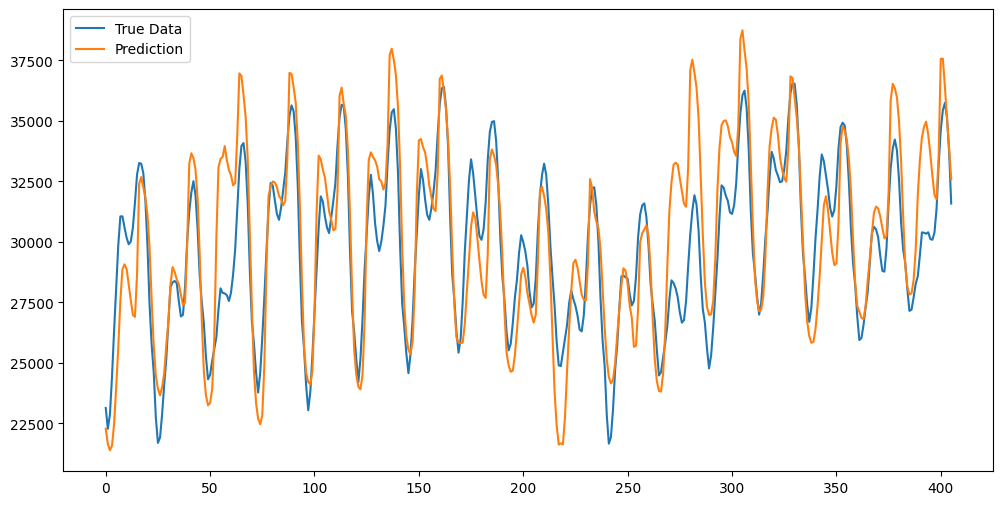

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(facecolor='white', figsize=(12, 6))
ax = fig.add_subplot(111)
ax.plot(pred[-1000:], label='True Data')
plt.plot(out[-1000:], label='Prediction')
plt.legend()
plt.show()

In [ ]:
mape_values7=[10.527130, 10.720422, 10.773411, 8.135247, 7.155310]
mape_values8 = [7.398506, 6.710972, 6.103504, 5.108923, 5.156514]
mape_errors7 = []
mape_errors8 = []
for i in mape_values7:
  mape_std = np.std(i)
  mape_errors7.append(mape_std)

for i in mape_values8:
  mape_std = np.std(i)
  mape_errors8.append(mape_std)

In [ ]:
import matplotlib.pyplot as plt

# Existing code for model evaluation and obtaining mape_values and mape_errors

# Plotting
fig = plt.figure(facecolor='white', figsize=(12, 6))
plt.errorbar(period_lengths, mape_values1, yerr=mape_errors1, fmt='o-', capsize=4, label='Model WLSTM')
plt.errorbar(period_lengths, mape_values2, yerr=mape_errors2, fmt='o-', capsize=4, label='Model WRNN')
plt.errorbar(period_lengths, mape_values3, yerr=mape_errors3, fmt='o-', capsize=4, label='Model WGRU')
plt.errorbar(period_lengths, mape_values4, yerr=mape_errors4, fmt='o-', capsize=4, label='Model LSTM')
plt.errorbar(period_lengths, mape_values5, yerr=mape_errors5, fmt='o-', capsize=4, label='Model RNN')
plt.errorbar(period_lengths, mape_values6, yerr=mape_errors6, fmt='o-', capsize=4, label='Model GRU')
plt.errorbar(period_lengths, mape_values7, yerr=mape_errors7, fmt='o-', capsize=4, label='Model Transformer')
plt.errorbar(period_lengths, mape_values8, yerr=mape_errors8, fmt='o-', capsize=4, label='Model W-Transformer')

plt.xlabel('Period Length')
plt.ylabel('MAPE')
plt.title('MAPE for Different Period Lengths')

plt.legend()
plt.show()


NameError: ignored

<Figure size 1200x600 with 0 Axes>